In [5]:
# imports and plotting utility functions
%matplotlib inline
import numpy as np
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import ShuffleSplit
from sklearn.linear_model import Lasso
import seaborn as sns
from matplotlib import pylab as plt
from statsmodels.regression.linear_model import OLS

def plot_lr(true_coefs, est_coefs, pvals):
    n_feat = len(est_coefs)
    where_sign = lr_pvalues < 0.05
    plt.figure(figsize=(15, 7))
    plt.scatter(np.arange(X.shape[1]), true_coefs, color='black', label='true betas', alpha=0.5)
    # print non-significant betas
    plt.scatter(np.arange(X.shape[1]), est_coefs, color='red', label='estimated betas', alpha=0.5)
    # print significant betas
    axes = plt.gca()
    y_max, _ = axes.get_ylim()
    sign_y = np.sum(where_sign) * [y_max]
    plt.scatter(np.arange(X.shape[1])[where_sign], sign_y, color='red', label='significant at p<0.05', s=150, marker=(5, 1), alpha=0.75, linewidth=3)

    plt.xlabel('input variables')
    #plt.xticks(np.arange(n_feat)[::2], (np.arange(n_feat) + 1)[::2])
    plt.xticks(np.arange(n_feat), (np.arange(n_feat) + 1))
    plt.grid(True)
    plt.title('Linear regression', fontsize=16)
    plt.legend(loc='upper right')

def plot_regr_paths(coefs, accs, nonzeros, C_grid):
    n_cols = 2
    n_rows = 1
    n_verticals = len(coefs)
    n_feat = coefs.shape[1]

    my_palette = np.array([
        '#F47D7D', '#FBEF69', '#98E466', '#000000',
        '#A7794F', '#CCCCCC', '#85359C', '#FF9300', '#FF0030', 'grey', 'blue', 'salmon', '#4BBCF6',
        'green', 'tomato', 'darkred', 'black', 'cyan', 'lime'
    ])
    my_colors = np.array(['???????'] * coefs.shape[-1])
    i_col = 0
    new_grp_pts_x = []
    new_grp_pts_y = []
    new_grp_pts_col = []
    new_grp_pts_total = []

    for i_vertical, (params, acc, C) in enumerate(zip(
        coefs, accs, C_grid)):
        b_notset = my_colors == '???????'
        b_nonzeros = params == 0
        b_coefs_of_new_grp = np.logical_and(b_notset, b_nonzeros)

        #if i_vertical >= 17:
        #    import pdb; pdb.set_trace()

        if np.sum(b_coefs_of_new_grp) > 0:
            i_col += 1

            # we found a new subset that became 0
            for new_i in np.where(b_coefs_of_new_grp == True)[0]:
                # color all coefficients of the current group
                cur_col = my_palette[i_col]
                my_colors[new_i] = cur_col

            new_grp_pts_x.append(C)
            new_grp_pts_y.append(acc)
            new_grp_pts_col.append(cur_col)
            new_grp_pts_total.append(np.sum(b_nonzeros))

    X_colnames = np.arange(n_feat) + 1
    subplot_xlabel = '#nonzero coefficients'

    f, axarr = plt.subplots(nrows=n_rows, ncols=n_cols,
        figsize=(15, 10), facecolor='white')
    t, i_col = 0, 0

    for i_line in range(X.shape[-1]):
        axarr[i_col].plot(np.log10(C_grid),
            coefs[:, i_line], label=X_colnames[i_line],
                color=my_colors[i_line], linewidth=1.5)

    # axarr[0].set_xticks(np.arange(len(C_grid)))
    # axarr[0].set_xticklabels(np.log10(C_grid))  #, rotation=75)
    axarr[i_col].set_xlabel(subplot_xlabel, fontsize=10)
    axarr[i_col].legend(loc='lower left', fontsize=8.5, markerscale=10)
    axarr[0].grid(True)
    # axarr[i_col].set_ylabel('Item groups', fontsize=16)
    axarr[0].set_title('LASSO: Groups of selected variables', fontsize=16)
    axarr[0].set_xticks(np.log10(C_grid))
    axarr[0].set_xticklabels(nonzeros)

    # axarr[1].axis('off')
    axarr[1].plot(np.arange(len(accs)), accs, color='#000000',
                     linewidth=3)
    # axarr[1].set_title('ACCURACY')
    axarr[1].set_ylim(0.0, 1.05)
    axarr[1].grid(True)
    # axarr[1].set_xticklabels(np.log10(C_grid), '')
    axarr[1].set_xticks(np.arange(n_verticals))
    axarr[1].set_xticklabels(nonzeros)
    axarr[1].set_xlabel(subplot_xlabel, fontsize=10)
    # axarr[1].set_ylabel('Out-of-sample accuracy', fontsize=16)
    axarr[1].set_title('LASSO: Out-of-sample accuracy ($R^2$ score)', fontsize=16)

In [3]:
# statistical helper functions
def compute_Lasso_regpath(X, y, C_grid):
    coef_list2 = []
    acc_list2 = []
    nonzero_list2 = []
    for i_step, my_C in enumerate(C_grid):
        sample_accs = []
        sample_coef = []
        for i_subsample in range(100):
            folder = ShuffleSplit(n=len(y), n_iter=100, test_size=0.1,
                                            random_state=i_subsample)
            train_inds, test_inds = iter(folder).next()

            clf = Lasso(alpha=my_C, random_state=i_subsample)

            clf.fit(X[train_inds, :], y[train_inds])
            acc = clf.score(X[test_inds, :], y[test_inds])

            sample_accs.append(acc)        
            sample_coef.append(clf.coef_)

        mean_coefs = np.mean(np.array(sample_coef), axis=0)
        coef_list2.append(mean_coefs)
        acc_list2.append(np.mean(sample_accs))
        notzero = np.count_nonzero(mean_coefs)
        print "alpha: %.4f acc: %.2f active_coefs: %i" % (my_C, acc, notzero)
        nonzero_list2.append(notzero)
    return np.array(coef_list2), np.array(acc_list2), np.array(nonzero_list2)

# __100 samples, 40 variables, error = N(0, 1)__

alpha: 0.0100 acc: 0.57 active_coefs: 40
alpha: 0.0127 acc: 0.60 active_coefs: 40
alpha: 0.0162 acc: 0.64 active_coefs: 40
alpha: 0.0205 acc: 0.68 active_coefs: 40
alpha: 0.0261 acc: 0.72 active_coefs: 40
alpha: 0.0332 acc: 0.76 active_coefs: 40
alpha: 0.0422 acc: 0.79 active_coefs: 40
alpha: 0.0536 acc: 0.80 active_coefs: 40
alpha: 0.0681 acc: 0.80 active_coefs: 40
alpha: 0.0866 acc: 0.80 active_coefs: 39
alpha: 0.1101 acc: 0.80 active_coefs: 32
alpha: 0.1399 acc: 0.78 active_coefs: 24
alpha: 0.1778 acc: 0.76 active_coefs: 19
alpha: 0.2260 acc: 0.70 active_coefs: 15
alpha: 0.2873 acc: 0.62 active_coefs: 13
alpha: 0.3652 acc: 0.55 active_coefs: 7
alpha: 0.4642 acc: 0.44 active_coefs: 6
alpha: 0.5900 acc: 0.32 active_coefs: 6
alpha: 0.7499 acc: 0.22 active_coefs: 4
alpha: 0.9532 acc: 0.04 active_coefs: 2
alpha: 1.2115 acc: -0.19 active_coefs: 2
alpha: 1.5399 acc: -0.22 active_coefs: 1
alpha: 1.9573 acc: -0.22 active_coefs: 0
alpha: 2.4879 acc: -0.22 active_coefs: 0
alpha: 3.1623 acc: -0

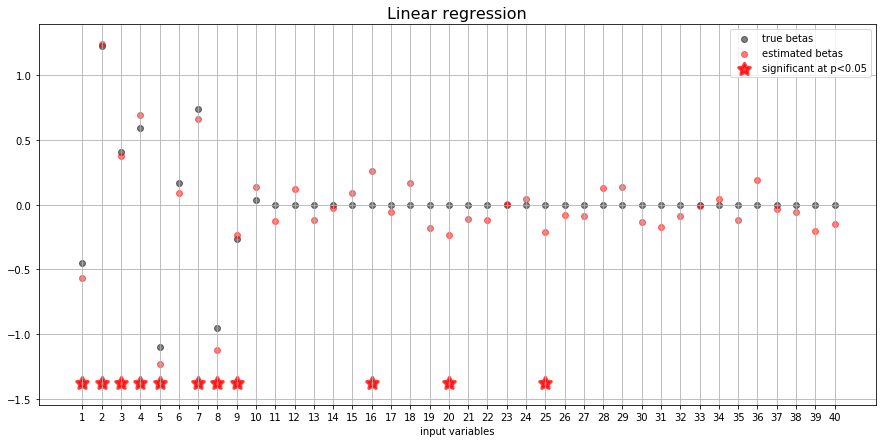

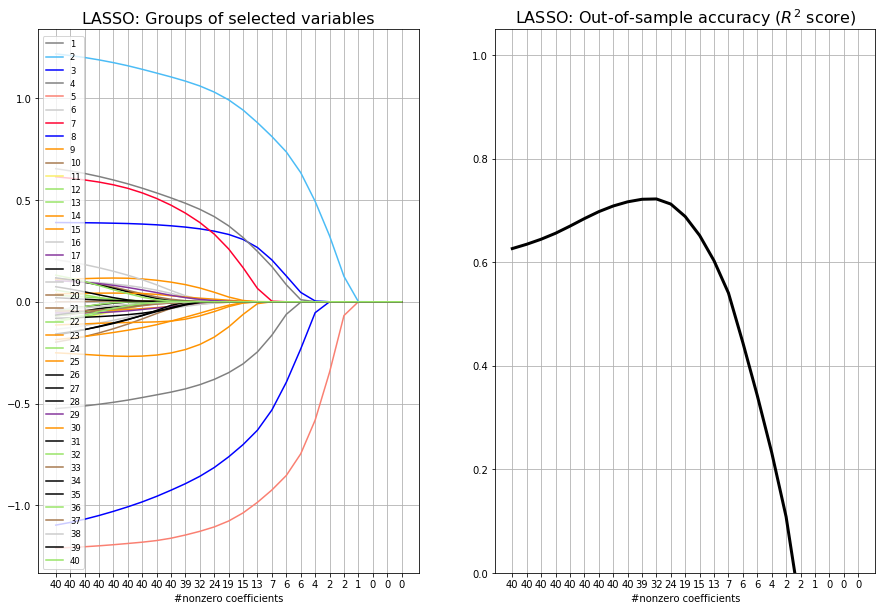

In [184]:
# dataset: 10/40 variables relevant, linear ground truth, some noise
rs = np.random.RandomState(1)
n_samples = 100
n_feat = 40
n_feat_relevant = 10
epsilon = rs.randn(n_samples)
true_coefs = rs.randn(n_feat)
true_coefs[n_feat_relevant:] = 0
X = rs.randn(n_samples, n_feat)
y = (true_coefs * X).sum(axis=1) + epsilon

# ordinary least squares
model = OLS(y, X)
res = model.fit()
lr_coefs = res.params
lr_pvalues = res.pvalues

# compute Lasso regularization paths
C_grid = np.logspace(-2, 0.5, 25)
coef_list, acc_list, nonzero_list = compute_Lasso_regpath(X, y, C_grid)

plot_lr(true_coefs, lr_coefs, lr_pvalues)
plot_regr_paths(coef_list, acc_list, nonzero_list, C_grid)

alpha: 0.0100 acc: 0.85 active_coefs: 40
alpha: 0.0127 acc: 0.86 active_coefs: 40
alpha: 0.0162 acc: 0.87 active_coefs: 40
alpha: 0.0205 acc: 0.87 active_coefs: 40
alpha: 0.0261 acc: 0.88 active_coefs: 40
alpha: 0.0332 acc: 0.89 active_coefs: 40
alpha: 0.0422 acc: 0.91 active_coefs: 40
alpha: 0.0536 acc: 0.91 active_coefs: 40
alpha: 0.0681 acc: 0.91 active_coefs: 38
alpha: 0.0866 acc: 0.90 active_coefs: 36
alpha: 0.1101 acc: 0.88 active_coefs: 35
alpha: 0.1399 acc: 0.85 active_coefs: 33
alpha: 0.1778 acc: 0.79 active_coefs: 28
alpha: 0.2260 acc: 0.71 active_coefs: 26
alpha: 0.2873 acc: 0.63 active_coefs: 25
alpha: 0.3652 acc: 0.52 active_coefs: 22
alpha: 0.4642 acc: 0.43 active_coefs: 19
alpha: 0.5900 acc: 0.31 active_coefs: 16
alpha: 0.7499 acc: 0.18 active_coefs: 11
alpha: 0.9532 acc: 0.00 active_coefs: 8
alpha: 1.2115 acc: -0.07 active_coefs: 7
alpha: 1.5399 acc: -0.07 active_coefs: 2
alpha: 1.9573 acc: -0.04 active_coefs: 0
alpha: 2.4879 acc: -0.04 active_coefs: 0
alpha: 3.1623 acc

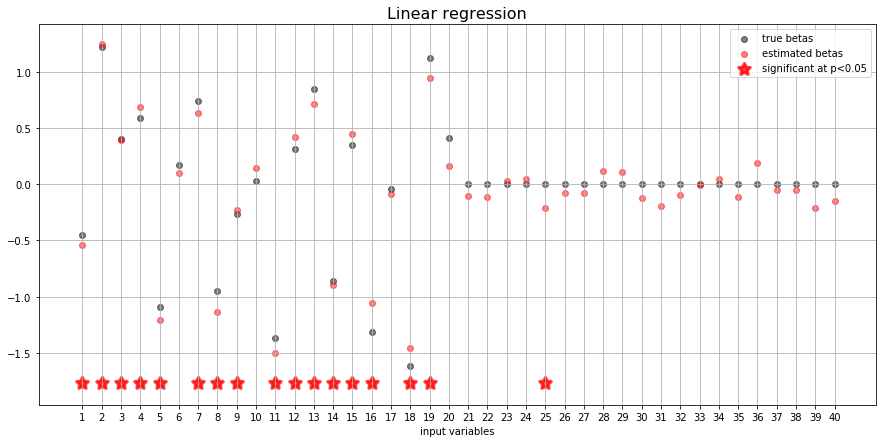

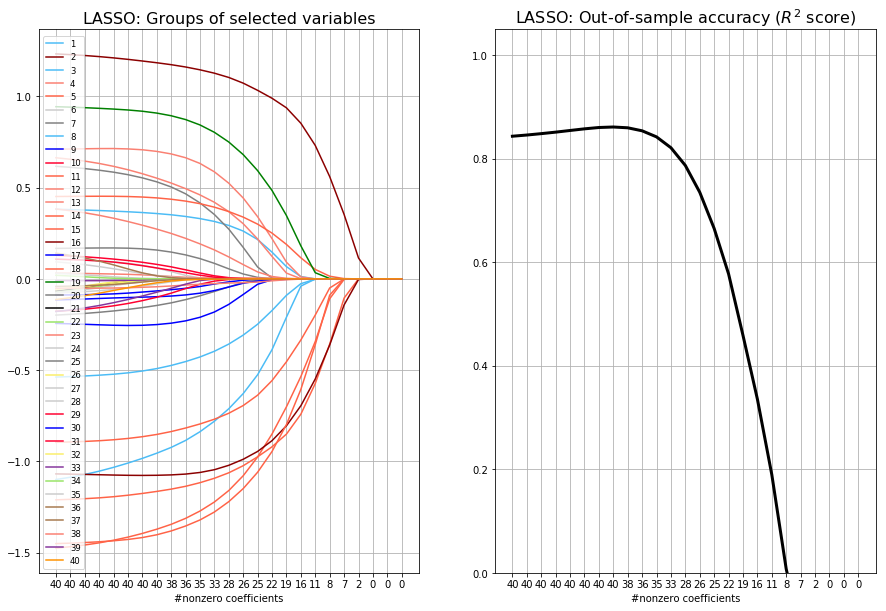

In [185]:
# dataset: 20/40 variables relevant, linear ground truth, some noise
rs = np.random.RandomState(1)
n_samples = 100
n_feat = 40
n_feat_relevant = 20
epsilon = rs.randn(n_samples)
true_coefs = rs.randn(n_feat)
true_coefs[n_feat_relevant:] = 0
X = rs.randn(n_samples, n_feat)
y = (true_coefs * X).sum(axis=1) + epsilon

# ordinary least squares
model = OLS(y, X)
res = model.fit()
lr_coefs = res.params
lr_pvalues = res.pvalues

# compute Lasso regularization paths
C_grid = np.logspace(-2, 0.5, 25)
coef_list, acc_list, nonzero_list = compute_Lasso_regpath(X, y, C_grid)

plot_lr(true_coefs, lr.coef_, lr_pvalues)
plot_regr_paths(coef_list, acc_list, nonzero_list, C_grid)

alpha: 0.0100 acc: 0.95 active_coefs: 40
alpha: 0.0127 acc: 0.95 active_coefs: 40
alpha: 0.0162 acc: 0.95 active_coefs: 40
alpha: 0.0205 acc: 0.95 active_coefs: 40
alpha: 0.0261 acc: 0.96 active_coefs: 40
alpha: 0.0332 acc: 0.96 active_coefs: 40
alpha: 0.0422 acc: 0.96 active_coefs: 40
alpha: 0.0536 acc: 0.96 active_coefs: 40
alpha: 0.0681 acc: 0.96 active_coefs: 38
alpha: 0.0866 acc: 0.96 active_coefs: 38
alpha: 0.1101 acc: 0.95 active_coefs: 37
alpha: 0.1399 acc: 0.93 active_coefs: 37
alpha: 0.1778 acc: 0.90 active_coefs: 34
alpha: 0.2260 acc: 0.86 active_coefs: 33
alpha: 0.2873 acc: 0.81 active_coefs: 31
alpha: 0.3652 acc: 0.75 active_coefs: 29
alpha: 0.4642 acc: 0.68 active_coefs: 28
alpha: 0.5900 acc: 0.58 active_coefs: 26
alpha: 0.7499 acc: 0.43 active_coefs: 23
alpha: 0.9532 acc: 0.22 active_coefs: 18
alpha: 1.2115 acc: -0.06 active_coefs: 14
alpha: 1.5399 acc: -0.25 active_coefs: 10
alpha: 1.9573 acc: -0.36 active_coefs: 5
alpha: 2.4879 acc: -0.45 active_coefs: 1
alpha: 3.1623 

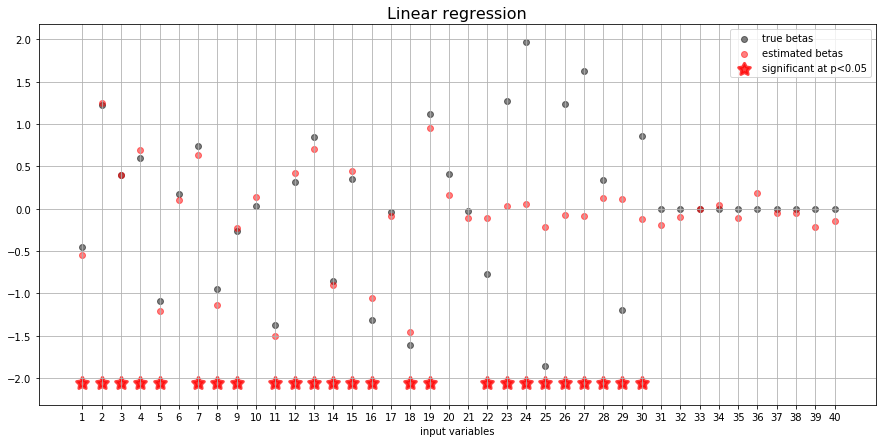

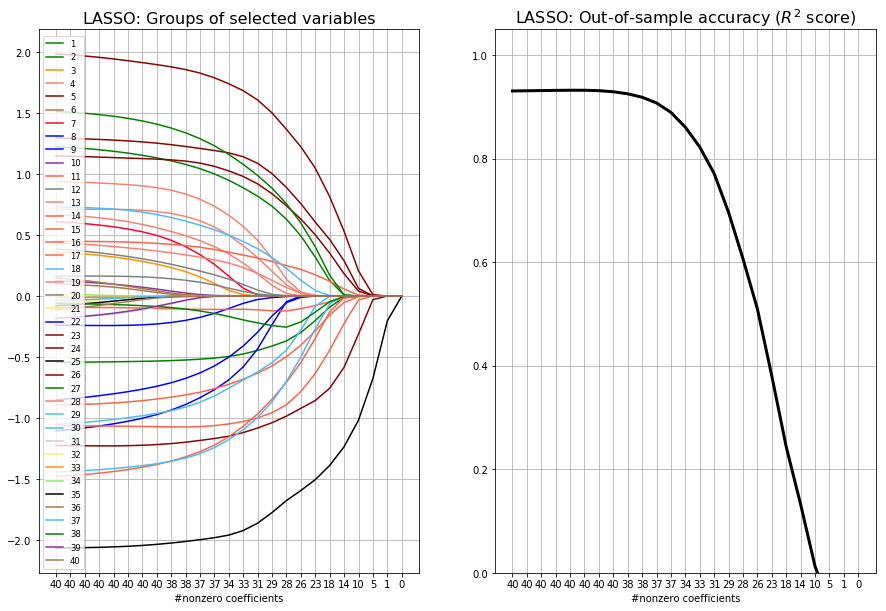

In [186]:
# dataset: 30/40 variables relevant, linear ground truth, some noise
rs = np.random.RandomState(1)
n_samples = 100
n_feat = 40
n_feat_relevant = 30
epsilon = rs.randn(n_samples)
true_coefs = rs.randn(n_feat)
true_coefs[n_feat_relevant:] = 0
X = rs.randn(n_samples, n_feat)
y = (true_coefs * X).sum(axis=1) + epsilon

# ordinary least squares
model = OLS(y, X)
res = model.fit()
lr_coefs = res.params
lr_pvalues = res.pvalues

# compute Lasso regularization paths
C_grid = np.logspace(-2, 0.5, 25)
coef_list, acc_list, nonzero_list = compute_Lasso_regpath(X, y, C_grid)

plot_lr(true_coefs, lr.coef_, lr_pvalues)
plot_regr_paths(coef_list, acc_list, nonzero_list, C_grid)

alpha: 0.0100 acc: 0.97 active_coefs: 40
alpha: 0.0127 acc: 0.97 active_coefs: 40
alpha: 0.0162 acc: 0.97 active_coefs: 40
alpha: 0.0205 acc: 0.97 active_coefs: 40
alpha: 0.0261 acc: 0.97 active_coefs: 40
alpha: 0.0332 acc: 0.98 active_coefs: 40
alpha: 0.0422 acc: 0.98 active_coefs: 40
alpha: 0.0536 acc: 0.98 active_coefs: 40
alpha: 0.0681 acc: 0.98 active_coefs: 40
alpha: 0.0866 acc: 0.97 active_coefs: 40
alpha: 0.1101 acc: 0.96 active_coefs: 40
alpha: 0.1399 acc: 0.94 active_coefs: 40
alpha: 0.1778 acc: 0.92 active_coefs: 40
alpha: 0.2260 acc: 0.88 active_coefs: 38
alpha: 0.2873 acc: 0.82 active_coefs: 36
alpha: 0.3652 acc: 0.75 active_coefs: 36
alpha: 0.4642 acc: 0.68 active_coefs: 33
alpha: 0.5900 acc: 0.59 active_coefs: 30
alpha: 0.7499 acc: 0.47 active_coefs: 29
alpha: 0.9532 acc: 0.30 active_coefs: 21
alpha: 1.2115 acc: 0.09 active_coefs: 17
alpha: 1.5399 acc: -0.11 active_coefs: 14
alpha: 1.9573 acc: -0.25 active_coefs: 8
alpha: 2.4879 acc: -0.31 active_coefs: 4
alpha: 3.1623 a

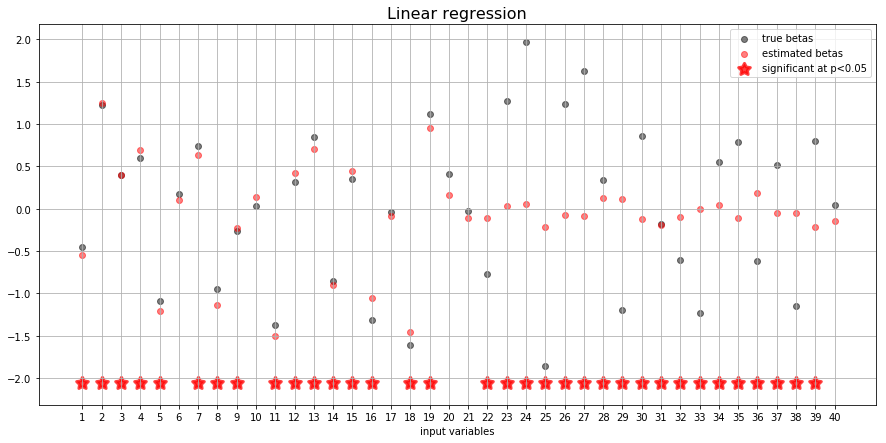

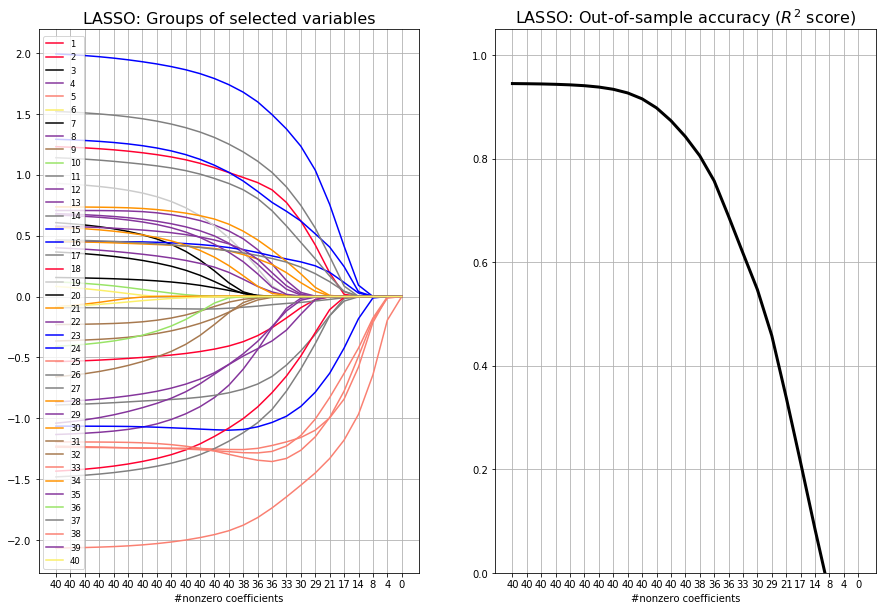

In [144]:
# dataset: 40/40 variables relevant, linear ground truth, some noise
rs = np.random.RandomState(1)
n_samples = 100
n_feat = 40
n_feat_relevant = 40
epsilon = rs.randn(n_samples)
true_coefs = rs.randn(n_feat)
true_coefs[n_feat_relevant:] = 0
X = rs.randn(n_samples, n_feat)
y = (true_coefs * X).sum(axis=1) + epsilon

# ordinary least squares
model = OLS(y, X)
res = model.fit()
lr_coefs = res.params
lr_pvalues = res.pvalues

# compute Lasso regularization paths
C_grid = np.logspace(-2, 0.5, 25)
coef_list, acc_list, nonzero_list = compute_Lasso_regpath(X, y, C_grid)

# plotting
plot_lr(true_coefs, lr.coef_, lr_pvalues)
plot_regr_paths(coef_list, acc_list, nonzero_list, C_grid)



# __1000 samples, 40 variables, error = N(0, 1)__

alpha: 0.0100 acc: 0.93 active_coefs: 40
alpha: 0.0127 acc: 0.93 active_coefs: 40
alpha: 0.0162 acc: 0.94 active_coefs: 40
alpha: 0.0205 acc: 0.94 active_coefs: 40
alpha: 0.0261 acc: 0.94 active_coefs: 38
alpha: 0.0332 acc: 0.94 active_coefs: 36
alpha: 0.0422 acc: 0.94 active_coefs: 28
alpha: 0.0536 acc: 0.94 active_coefs: 20
alpha: 0.0681 acc: 0.93 active_coefs: 16
alpha: 0.0866 acc: 0.93 active_coefs: 12
alpha: 0.1101 acc: 0.93 active_coefs: 11
alpha: 0.1399 acc: 0.92 active_coefs: 10
alpha: 0.1778 acc: 0.91 active_coefs: 10
alpha: 0.2260 acc: 0.90 active_coefs: 9
alpha: 0.2873 acc: 0.88 active_coefs: 8
alpha: 0.3652 acc: 0.86 active_coefs: 8
alpha: 0.4642 acc: 0.81 active_coefs: 8
alpha: 0.5900 acc: 0.75 active_coefs: 7
alpha: 0.7499 acc: 0.67 active_coefs: 5
alpha: 0.9532 acc: 0.56 active_coefs: 4
alpha: 1.2115 acc: 0.41 active_coefs: 3
alpha: 1.5399 acc: 0.19 active_coefs: 3
alpha: 1.9573 acc: 0.09 active_coefs: 1
alpha: 2.4879 acc: -0.00 active_coefs: 0
alpha: 3.1623 acc: -0.00 a

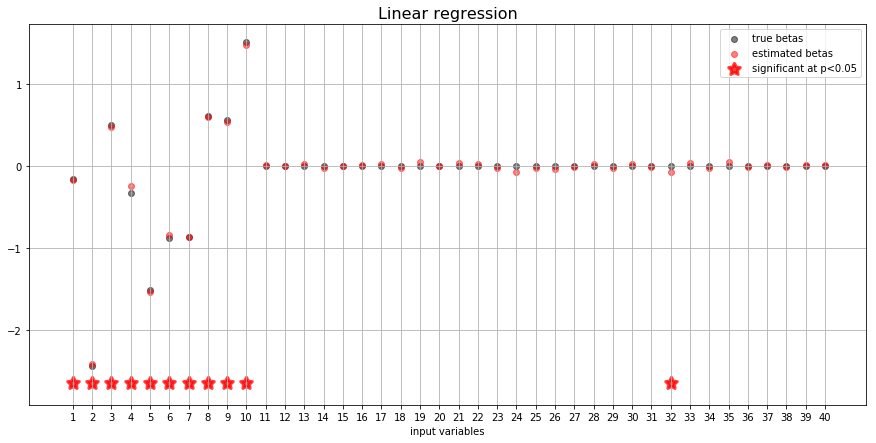

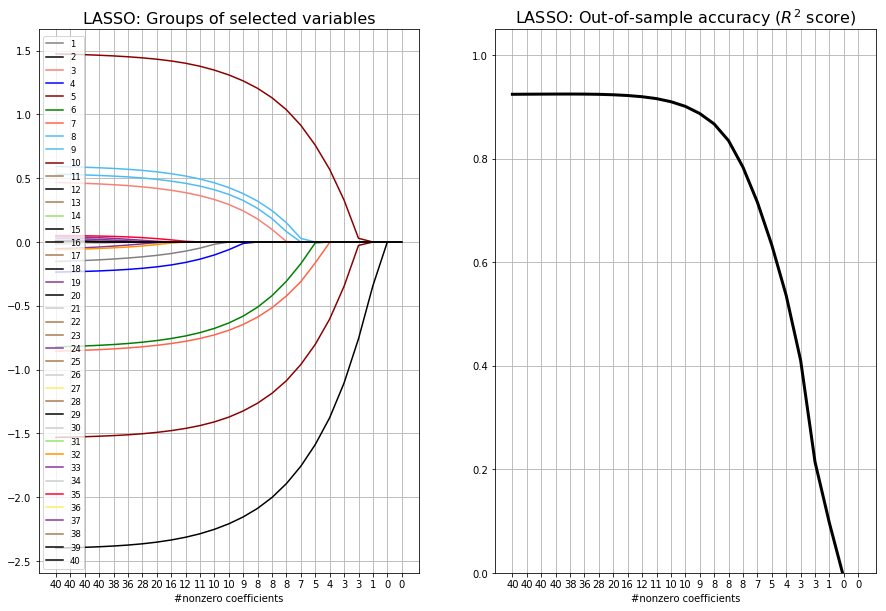

In [79]:
# dataset: 10/40 variables relevant, linear ground truth, some noise
rs = np.random.RandomState(1)
n_samples = 1000
n_feat = 40
n_feat_relevant = 10
epsilon = rs.randn(n_samples)
true_coefs = rs.randn(n_feat)
true_coefs[n_feat_relevant:] = 0
X = rs.randn(n_samples, n_feat)
y = (true_coefs * X).sum(axis=1) + epsilon

# ordinary least squares
model = OLS(y, X)
res = model.fit()
lr_coefs = res.params
lr_pvalues = res.pvalues

# compute Lasso regularization paths
C_grid = np.logspace(-2, 0.5, 25)
coef_list, acc_list, nonzero_list = compute_Lasso_regpath(X, y, C_grid)

# plotting
plot_lr(true_coefs, lr_coefs, lr_pvalues)
plot_regr_paths(coef_list, acc_list, nonzero_list, C_grid)

alpha: 0.0100 acc: 0.96 active_coefs: 40
alpha: 0.0127 acc: 0.96 active_coefs: 40
alpha: 0.0162 acc: 0.97 active_coefs: 40
alpha: 0.0205 acc: 0.97 active_coefs: 40
alpha: 0.0261 acc: 0.97 active_coefs: 38
alpha: 0.0332 acc: 0.97 active_coefs: 37
alpha: 0.0422 acc: 0.97 active_coefs: 35
alpha: 0.0536 acc: 0.97 active_coefs: 29
alpha: 0.0681 acc: 0.97 active_coefs: 24
alpha: 0.0866 acc: 0.96 active_coefs: 22
alpha: 0.1101 acc: 0.96 active_coefs: 21
alpha: 0.1399 acc: 0.96 active_coefs: 21
alpha: 0.1778 acc: 0.95 active_coefs: 19
alpha: 0.2260 acc: 0.94 active_coefs: 19
alpha: 0.2873 acc: 0.93 active_coefs: 18
alpha: 0.3652 acc: 0.90 active_coefs: 17
alpha: 0.4642 acc: 0.86 active_coefs: 17
alpha: 0.5900 acc: 0.81 active_coefs: 17
alpha: 0.7499 acc: 0.73 active_coefs: 12
alpha: 0.9532 acc: 0.61 active_coefs: 11
alpha: 1.2115 acc: 0.43 active_coefs: 10
alpha: 1.5399 acc: 0.19 active_coefs: 6
alpha: 1.9573 acc: 0.08 active_coefs: 1
alpha: 2.4879 acc: -0.00 active_coefs: 1
alpha: 3.1623 acc:

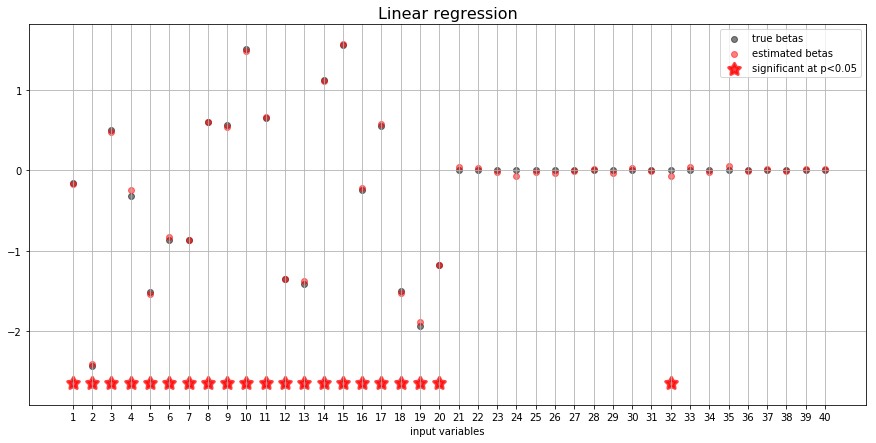

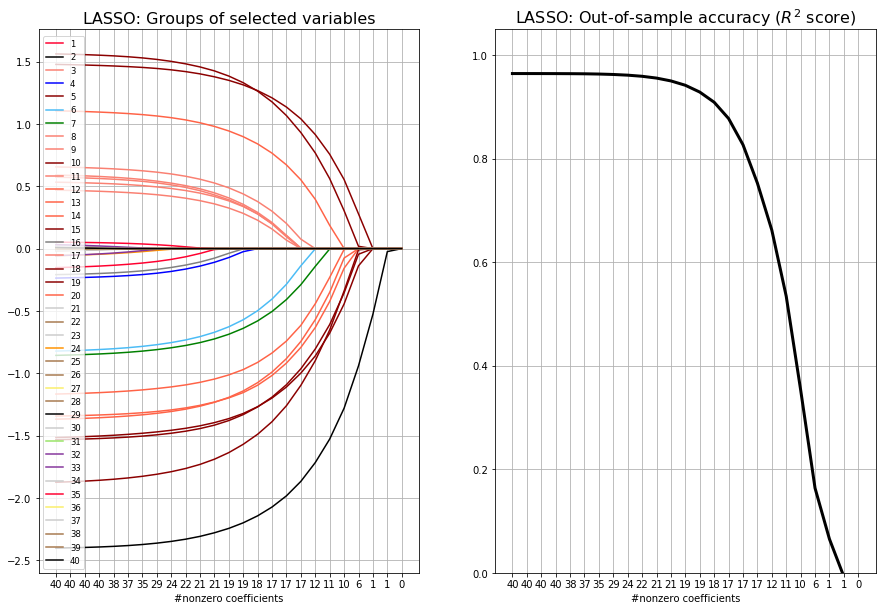

In [80]:
# dataset: 20/40 variables relevant, linear ground truth, some noise
rs = np.random.RandomState(1)
n_samples = 1000
n_feat = 40
n_feat_relevant = 20
epsilon = rs.randn(n_samples)
true_coefs = rs.randn(n_feat)
true_coefs[n_feat_relevant:] = 0
X = rs.randn(n_samples, n_feat)
y = (true_coefs * X).sum(axis=1) + epsilon

# ordinary least squares
model = OLS(y, X)
res = model.fit()
lr_coefs = res.params
lr_pvalues = res.pvalues

# compute Lasso regularization paths
C_grid = np.logspace(-2, 0.5, 25)
coef_list, acc_list, nonzero_list = compute_Lasso_regpath(X, y, C_grid)

# plotting
plot_lr(true_coefs, lr_coefs, lr_pvalues)
plot_regr_paths(coef_list, acc_list, nonzero_list, C_grid)

alpha: 0.0100 acc: 0.97 active_coefs: 40
alpha: 0.0127 acc: 0.97 active_coefs: 40
alpha: 0.0162 acc: 0.97 active_coefs: 40
alpha: 0.0205 acc: 0.97 active_coefs: 40
alpha: 0.0261 acc: 0.97 active_coefs: 40
alpha: 0.0332 acc: 0.97 active_coefs: 39
alpha: 0.0422 acc: 0.97 active_coefs: 37
alpha: 0.0536 acc: 0.97 active_coefs: 35
alpha: 0.0681 acc: 0.97 active_coefs: 32
alpha: 0.0866 acc: 0.97 active_coefs: 31
alpha: 0.1101 acc: 0.97 active_coefs: 30
alpha: 0.1399 acc: 0.96 active_coefs: 30
alpha: 0.1778 acc: 0.95 active_coefs: 28
alpha: 0.2260 acc: 0.94 active_coefs: 28
alpha: 0.2873 acc: 0.92 active_coefs: 26
alpha: 0.3652 acc: 0.90 active_coefs: 24
alpha: 0.4642 acc: 0.85 active_coefs: 23
alpha: 0.5900 acc: 0.80 active_coefs: 19
alpha: 0.7499 acc: 0.72 active_coefs: 15
alpha: 0.9532 acc: 0.62 active_coefs: 13
alpha: 1.2115 acc: 0.44 active_coefs: 12
alpha: 1.5399 acc: 0.23 active_coefs: 7
alpha: 1.9573 acc: 0.10 active_coefs: 3
alpha: 2.4879 acc: 0.01 active_coefs: 1
alpha: 3.1623 acc: 

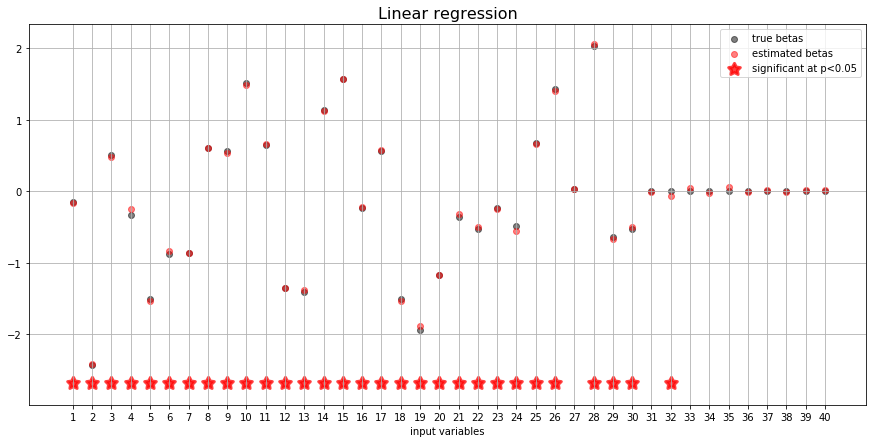

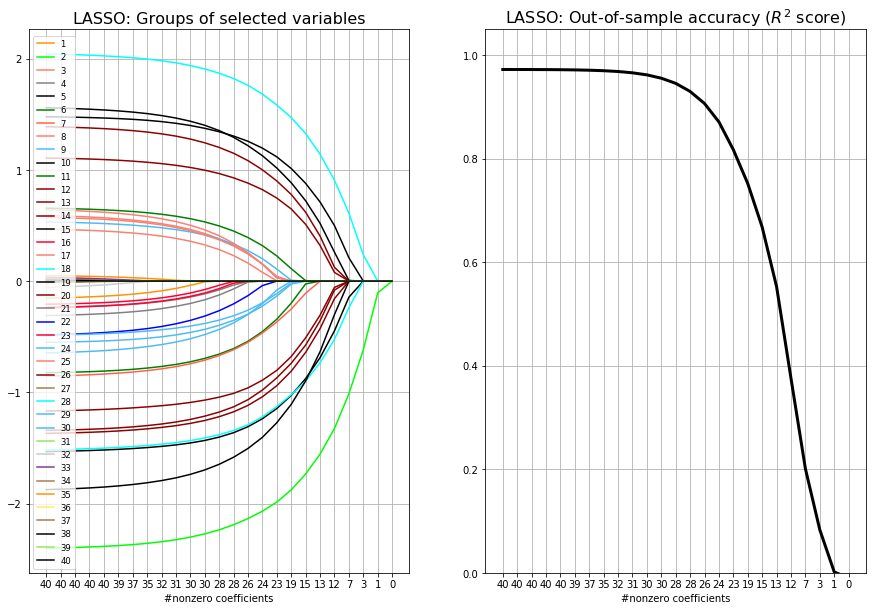

In [81]:
# dataset: 30/40 variables relevant, linear ground truth, some noise
rs = np.random.RandomState(1)
n_samples = 1000
n_feat = 40
n_feat_relevant = 30
epsilon = rs.randn(n_samples)
true_coefs = rs.randn(n_feat)
true_coefs[n_feat_relevant:] = 0
X = rs.randn(n_samples, n_feat)
y = (true_coefs * X).sum(axis=1) + epsilon

# ordinary least squares
model = OLS(y, X)
res = model.fit()
lr_coefs = res.params
lr_pvalues = res.pvalues

# compute Lasso regularization paths
C_grid = np.logspace(-2, 0.5, 25)
coef_list, acc_list, nonzero_list = compute_Lasso_regpath(X, y, C_grid)

# plotting
plot_lr(true_coefs, lr_coefs, lr_pvalues)
plot_regr_paths(coef_list, acc_list, nonzero_list, C_grid)

alpha: 0.0100 acc: 0.98 active_coefs: 40
alpha: 0.0127 acc: 0.98 active_coefs: 40
alpha: 0.0162 acc: 0.98 active_coefs: 40
alpha: 0.0205 acc: 0.98 active_coefs: 40
alpha: 0.0261 acc: 0.98 active_coefs: 40
alpha: 0.0332 acc: 0.98 active_coefs: 40
alpha: 0.0422 acc: 0.98 active_coefs: 40
alpha: 0.0536 acc: 0.98 active_coefs: 40
alpha: 0.0681 acc: 0.98 active_coefs: 39
alpha: 0.0866 acc: 0.97 active_coefs: 39
alpha: 0.1101 acc: 0.97 active_coefs: 39
alpha: 0.1399 acc: 0.96 active_coefs: 39
alpha: 0.1778 acc: 0.95 active_coefs: 39
alpha: 0.2260 acc: 0.94 active_coefs: 36
alpha: 0.2873 acc: 0.92 active_coefs: 34
alpha: 0.3652 acc: 0.89 active_coefs: 31
alpha: 0.4642 acc: 0.85 active_coefs: 29
alpha: 0.5900 acc: 0.79 active_coefs: 26
alpha: 0.7499 acc: 0.71 active_coefs: 21
alpha: 0.9532 acc: 0.61 active_coefs: 16
alpha: 1.2115 acc: 0.45 active_coefs: 15
alpha: 1.5399 acc: 0.28 active_coefs: 9
alpha: 1.9573 acc: 0.12 active_coefs: 6
alpha: 2.4879 acc: 0.01 active_coefs: 2
alpha: 3.1623 acc: 

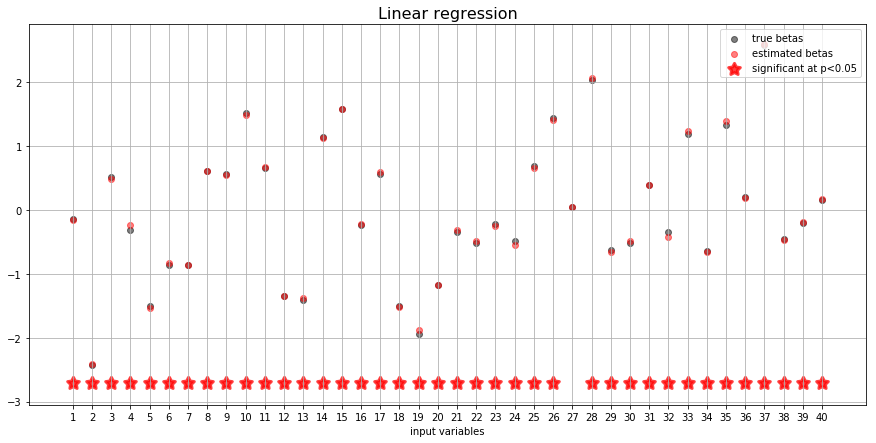

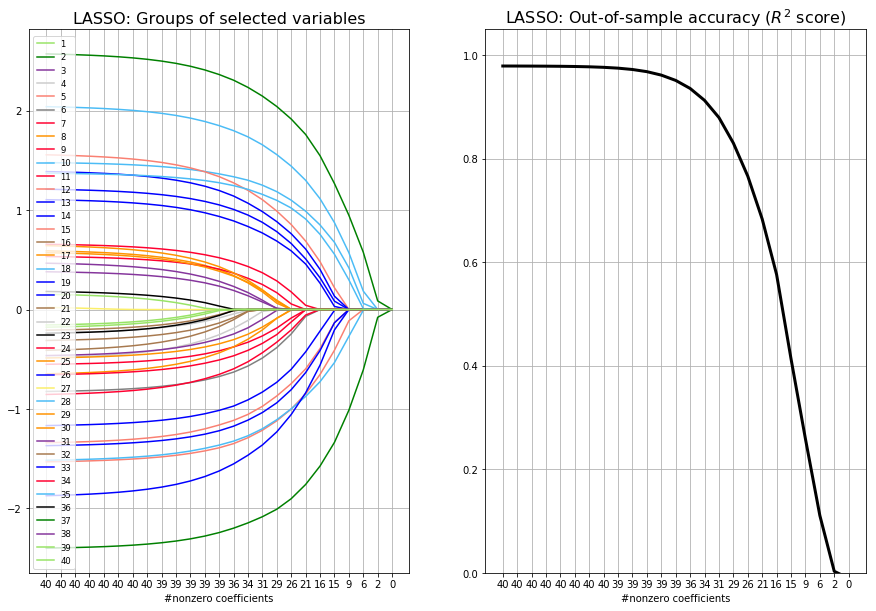

In [82]:
# dataset: 40/40 variables relevant, linear ground truth, some noise
rs = np.random.RandomState(1)
n_samples = 1000
n_feat = 40
n_feat_relevant = 40
epsilon = rs.randn(n_samples)
true_coefs = rs.randn(n_feat)
true_coefs[n_feat_relevant:] = 0
X = rs.randn(n_samples, n_feat)
y = (true_coefs * X).sum(axis=1) + epsilon

# ordinary least squares
model = OLS(y, X)
res = model.fit()
lr_coefs = res.params
lr_pvalues = res.pvalues

# compute Lasso regularization paths
C_grid = np.logspace(-2, 0.5, 25)
coef_list, acc_list, nonzero_list = compute_Lasso_regpath(X, y, C_grid)

# plotting
plot_lr(true_coefs, lr_coefs, lr_pvalues)
plot_regr_paths(coef_list, acc_list, nonzero_list, C_grid)

# __100 samples, 40 variables, error = none__

alpha: 0.0010 acc: 1.00 active_coefs: 10
alpha: 0.0014 acc: 1.00 active_coefs: 10
alpha: 0.0020 acc: 1.00 active_coefs: 10
alpha: 0.0027 acc: 1.00 active_coefs: 10
alpha: 0.0038 acc: 1.00 active_coefs: 10
alpha: 0.0054 acc: 1.00 active_coefs: 10
alpha: 0.0075 acc: 1.00 active_coefs: 10
alpha: 0.0105 acc: 1.00 active_coefs: 10
alpha: 0.0147 acc: 1.00 active_coefs: 10
alpha: 0.0205 acc: 1.00 active_coefs: 10
alpha: 0.0287 acc: 1.00 active_coefs: 10
alpha: 0.0402 acc: 1.00 active_coefs: 10
alpha: 0.0562 acc: 1.00 active_coefs: 10
alpha: 0.0787 acc: 0.99 active_coefs: 10
alpha: 0.1101 acc: 0.99 active_coefs: 10
alpha: 0.1540 acc: 0.98 active_coefs: 10
alpha: 0.2154 acc: 0.96 active_coefs: 10
alpha: 0.3014 acc: 0.93 active_coefs: 10
alpha: 0.4217 acc: 0.89 active_coefs: 8
alpha: 0.5900 acc: 0.80 active_coefs: 7
alpha: 0.8254 acc: 0.68 active_coefs: 6
alpha: 1.1548 acc: 0.47 active_coefs: 5
alpha: 1.6156 acc: 0.18 active_coefs: 3
alpha: 2.2603 acc: -0.05 active_coefs: 1
alpha: 3.1623 acc: -0

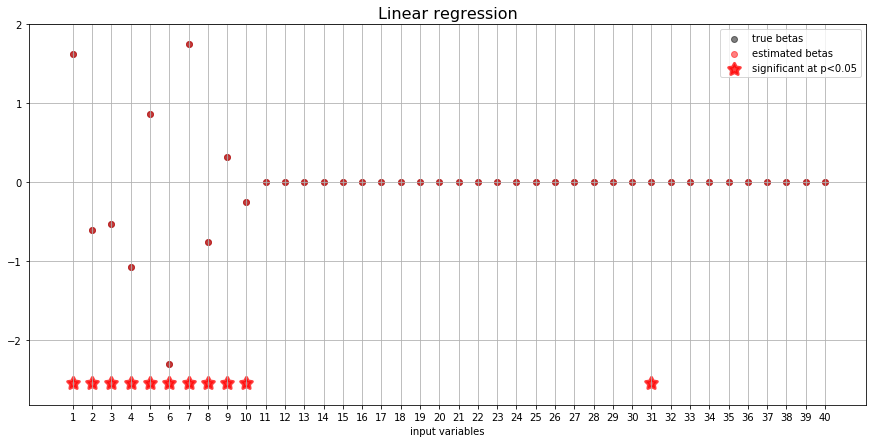

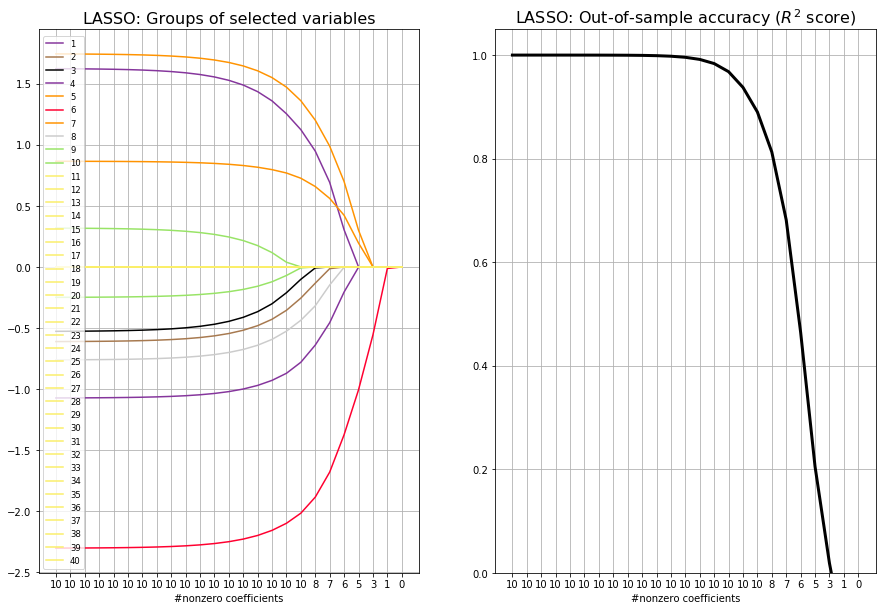

In [83]:
# dataset: 10/40 variables relevant, linear ground truth, some noise
rs = np.random.RandomState(1)
n_samples = 100
n_feat = 40
n_feat_relevant = 10
true_coefs = rs.randn(n_feat)
true_coefs[n_feat_relevant:] = 0
X = rs.randn(n_samples, n_feat)
y = (true_coefs * X).sum(axis=1)

# ordinary least squares
model = OLS(y, X)
res = model.fit()
lr_coefs = res.params
lr_pvalues = res.pvalues

# compute Lasso regularization paths
C_grid = np.logspace(-3, 0.5, 25)
coef_list, acc_list, nonzero_list = compute_Lasso_regpath(X, y, C_grid)

plot_lr(true_coefs, lr_coefs, lr_pvalues)
plot_regr_paths(coef_list, acc_list, nonzero_list, C_grid)

alpha: 0.0010 acc: 1.00 active_coefs: 25
alpha: 0.0014 acc: 1.00 active_coefs: 24
alpha: 0.0020 acc: 1.00 active_coefs: 24
alpha: 0.0027 acc: 1.00 active_coefs: 24
alpha: 0.0038 acc: 1.00 active_coefs: 24
alpha: 0.0054 acc: 1.00 active_coefs: 24
alpha: 0.0075 acc: 1.00 active_coefs: 24
alpha: 0.0105 acc: 1.00 active_coefs: 24
alpha: 0.0147 acc: 1.00 active_coefs: 24
alpha: 0.0205 acc: 1.00 active_coefs: 24
alpha: 0.0287 acc: 1.00 active_coefs: 24
alpha: 0.0402 acc: 1.00 active_coefs: 22
alpha: 0.0562 acc: 1.00 active_coefs: 23
alpha: 0.0787 acc: 0.99 active_coefs: 23
alpha: 0.1101 acc: 0.98 active_coefs: 24
alpha: 0.1540 acc: 0.97 active_coefs: 24
alpha: 0.2154 acc: 0.94 active_coefs: 22
alpha: 0.3014 acc: 0.90 active_coefs: 20
alpha: 0.4217 acc: 0.83 active_coefs: 17
alpha: 0.5900 acc: 0.69 active_coefs: 14
alpha: 0.8254 acc: 0.39 active_coefs: 13
alpha: 1.1548 acc: 0.00 active_coefs: 12
alpha: 1.6156 acc: -0.69 active_coefs: 7
alpha: 2.2603 acc: -1.09 active_coefs: 2
alpha: 3.1623 ac

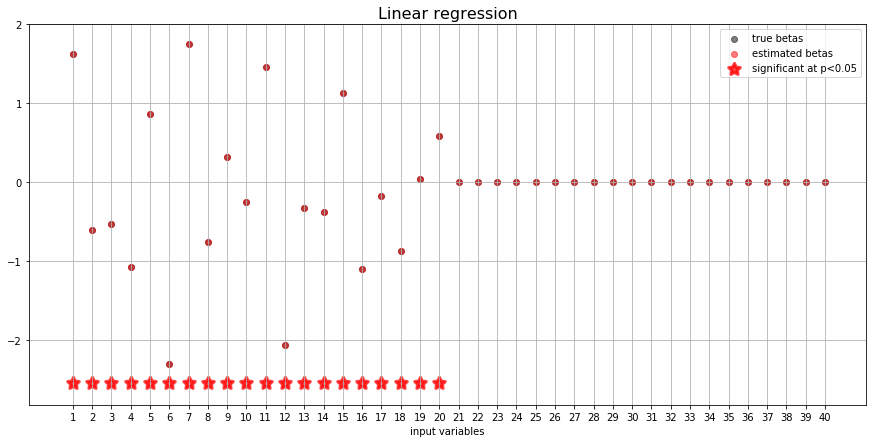

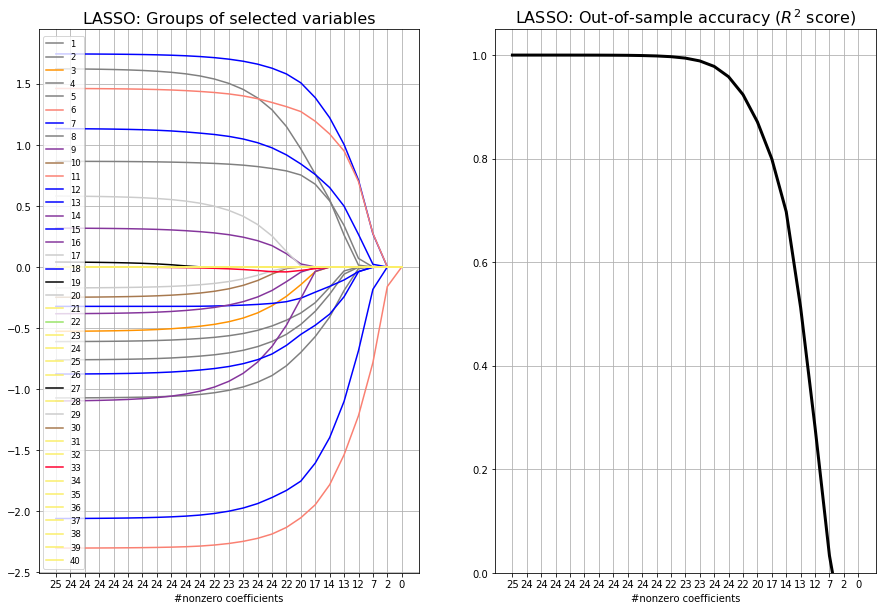

In [84]:
# dataset: 20/40 variables relevant, linear ground truth, some noise
rs = np.random.RandomState(1)
n_samples = 100
n_feat = 40
n_feat_relevant = 20
true_coefs = rs.randn(n_feat)
true_coefs[n_feat_relevant:] = 0
X = rs.randn(n_samples, n_feat)
y = (true_coefs * X).sum(axis=1)

# ordinary least squares
model = OLS(y, X)
res = model.fit()
lr_coefs = res.params
lr_pvalues = res.pvalues

# compute Lasso regularization paths
C_grid = np.logspace(-3, 0.5, 25)
coef_list, acc_list, nonzero_list = compute_Lasso_regpath(X, y, C_grid)

plot_lr(true_coefs, lr_coefs, lr_pvalues)
plot_regr_paths(coef_list, acc_list, nonzero_list, C_grid)

alpha: 0.0010 acc: 1.00 active_coefs: 38
alpha: 0.0014 acc: 1.00 active_coefs: 38
alpha: 0.0020 acc: 1.00 active_coefs: 38
alpha: 0.0027 acc: 1.00 active_coefs: 38
alpha: 0.0038 acc: 1.00 active_coefs: 38
alpha: 0.0054 acc: 1.00 active_coefs: 38
alpha: 0.0075 acc: 1.00 active_coefs: 38
alpha: 0.0105 acc: 1.00 active_coefs: 38
alpha: 0.0147 acc: 1.00 active_coefs: 38
alpha: 0.0205 acc: 1.00 active_coefs: 38
alpha: 0.0287 acc: 0.99 active_coefs: 38
alpha: 0.0402 acc: 0.99 active_coefs: 38
alpha: 0.0562 acc: 0.97 active_coefs: 38
alpha: 0.0787 acc: 0.95 active_coefs: 38
alpha: 0.1101 acc: 0.91 active_coefs: 37
alpha: 0.1540 acc: 0.83 active_coefs: 35
alpha: 0.2154 acc: 0.69 active_coefs: 35
alpha: 0.3014 acc: 0.50 active_coefs: 34
alpha: 0.4217 acc: 0.23 active_coefs: 28
alpha: 0.5900 acc: -0.25 active_coefs: 23
alpha: 0.8254 acc: -0.74 active_coefs: 20
alpha: 1.1548 acc: -0.97 active_coefs: 17
alpha: 1.6156 acc: -1.18 active_coefs: 9
alpha: 2.2603 acc: -1.40 active_coefs: 2
alpha: 3.1623

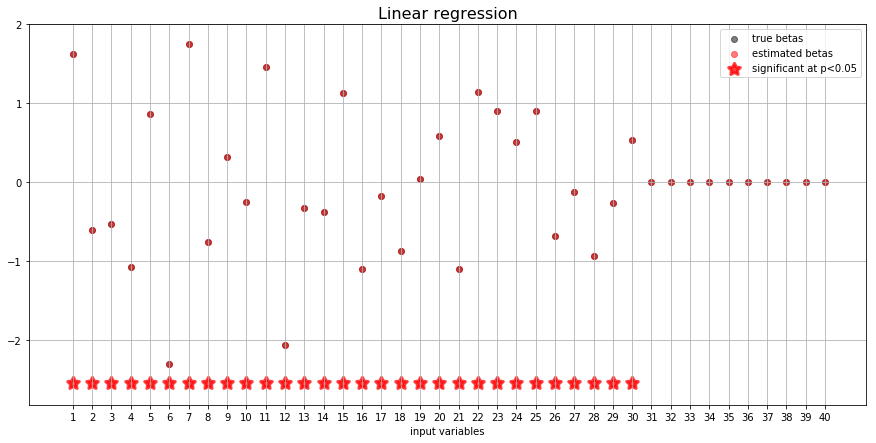

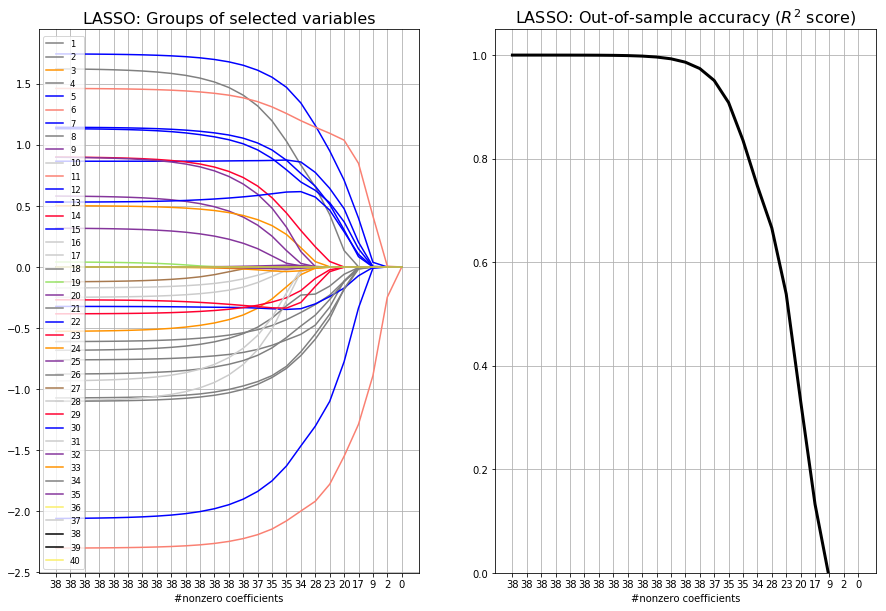

In [85]:
# dataset: 30/40 variables relevant, linear ground truth, some noise
rs = np.random.RandomState(1)
n_samples = 100
n_feat = 40
n_feat_relevant = 30
true_coefs = rs.randn(n_feat)
true_coefs[n_feat_relevant:] = 0
X = rs.randn(n_samples, n_feat)
y = (true_coefs * X).sum(axis=1)

# ordinary least squares
model = OLS(y, X)
res = model.fit()
lr_coefs = res.params
lr_pvalues = res.pvalues

# compute Lasso regularization paths
C_grid = np.logspace(-3, 0.5, 25)
coef_list, acc_list, nonzero_list = compute_Lasso_regpath(X, y, C_grid)

plot_lr(true_coefs, lr_coefs, lr_pvalues)
plot_regr_paths(coef_list, acc_list, nonzero_list, C_grid)

alpha: 0.0010 acc: 1.00 active_coefs: 40
alpha: 0.0014 acc: 1.00 active_coefs: 40
alpha: 0.0020 acc: 1.00 active_coefs: 40
alpha: 0.0027 acc: 1.00 active_coefs: 40
alpha: 0.0038 acc: 1.00 active_coefs: 40
alpha: 0.0054 acc: 1.00 active_coefs: 40
alpha: 0.0075 acc: 1.00 active_coefs: 40
alpha: 0.0105 acc: 1.00 active_coefs: 40
alpha: 0.0147 acc: 1.00 active_coefs: 40
alpha: 0.0205 acc: 1.00 active_coefs: 40
alpha: 0.0287 acc: 0.99 active_coefs: 40
alpha: 0.0402 acc: 0.98 active_coefs: 40
alpha: 0.0562 acc: 0.97 active_coefs: 40
alpha: 0.0787 acc: 0.94 active_coefs: 40
alpha: 0.1101 acc: 0.88 active_coefs: 40
alpha: 0.1540 acc: 0.81 active_coefs: 40
alpha: 0.2154 acc: 0.68 active_coefs: 38
alpha: 0.3014 acc: 0.53 active_coefs: 37
alpha: 0.4217 acc: 0.37 active_coefs: 35
alpha: 0.5900 acc: 0.13 active_coefs: 31
alpha: 0.8254 acc: -0.17 active_coefs: 27
alpha: 1.1548 acc: -0.21 active_coefs: 23
alpha: 1.6156 acc: -0.30 active_coefs: 11
alpha: 2.2603 acc: -0.51 active_coefs: 3
alpha: 3.1623

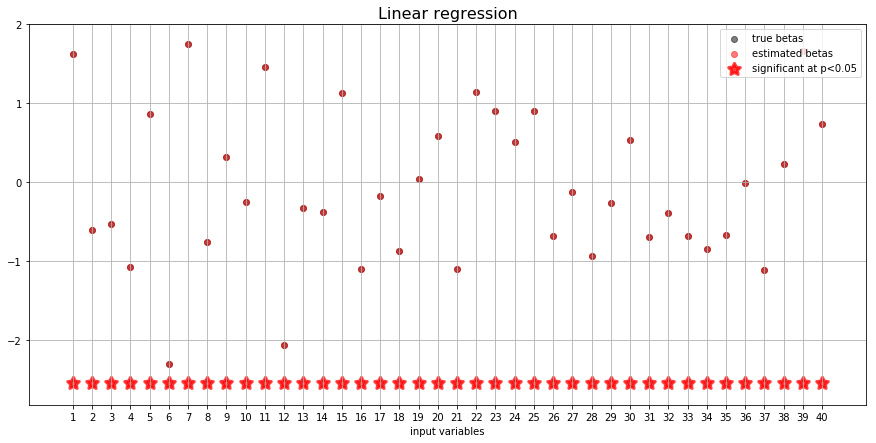

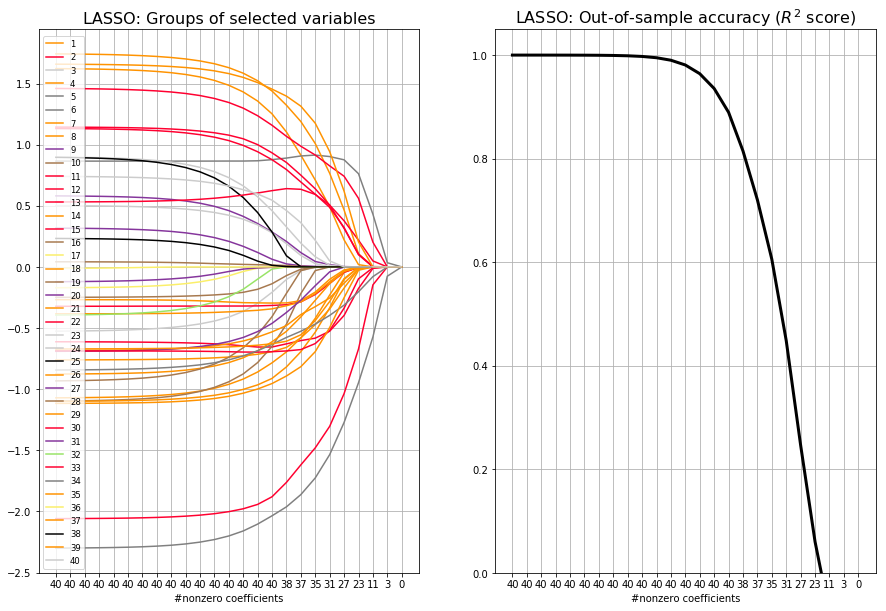

In [86]:
# dataset: 40/40 variables relevant, linear ground truth, some noise
rs = np.random.RandomState(1)
n_samples = 100
n_feat = 40
n_feat_relevant = 40
true_coefs = rs.randn(n_feat)
true_coefs[n_feat_relevant:] = 0
X = rs.randn(n_samples, n_feat)
y = (true_coefs * X).sum(axis=1)

# ordinary least squares
model = OLS(y, X)
res = model.fit()
lr_coefs = res.params
lr_pvalues = res.pvalues

# compute Lasso regularization paths
C_grid = np.logspace(-3, 0.5, 25)
coef_list, acc_list, nonzero_list = compute_Lasso_regpath(X, y, C_grid)

plot_lr(true_coefs, lr_coefs, lr_pvalues)
plot_regr_paths(coef_list, acc_list, nonzero_list, C_grid)

# __Pathological cases with diverging ground-truth model (abs, log, exp, sqrt, 1/x): 1000 samples, 40 variables, error = N(0,1)__

alpha: 0.0562 acc: 0.47 active_coefs: 38
alpha: 0.0649 acc: 0.47 active_coefs: 38
alpha: 0.0750 acc: 0.47 active_coefs: 32
alpha: 0.0866 acc: 0.48 active_coefs: 28
alpha: 0.1000 acc: 0.48 active_coefs: 20
alpha: 0.1155 acc: 0.48 active_coefs: 16
alpha: 0.1334 acc: 0.48 active_coefs: 13
alpha: 0.1540 acc: 0.48 active_coefs: 8
alpha: 0.1778 acc: 0.48 active_coefs: 7
alpha: 0.2054 acc: 0.47 active_coefs: 5
alpha: 0.2371 acc: 0.47 active_coefs: 4
alpha: 0.2738 acc: 0.46 active_coefs: 4
alpha: 0.3162 acc: 0.45 active_coefs: 4
alpha: 0.3652 acc: 0.43 active_coefs: 4
alpha: 0.4217 acc: 0.41 active_coefs: 4
alpha: 0.4870 acc: 0.37 active_coefs: 4
alpha: 0.5623 acc: 0.33 active_coefs: 4
alpha: 0.6494 acc: 0.30 active_coefs: 4
alpha: 0.7499 acc: 0.27 active_coefs: 2
alpha: 0.8660 acc: 0.23 active_coefs: 2
alpha: 1.0000 acc: 0.18 active_coefs: 1
alpha: 1.1548 acc: 0.13 active_coefs: 1
alpha: 1.3335 acc: 0.05 active_coefs: 1
alpha: 1.5399 acc: -0.04 active_coefs: 1
alpha: 1.7783 acc: -0.04 active_

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.204
Model:                            OLS   Adj. R-squared:                  0.170
Method:                 Least Squares   F-statistic:                     6.134
Date:                Wed, 21 Mar 2018   Prob (F-statistic):           3.31e-27
Time:                        17:01:23   Log-Likelihood:                -2879.8
No. Observations:                1000   AIC:                             5840.
Df Residuals:                     960   BIC:                             6036.
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0257      0.142      0.181      0.856      -0.253       0.304
x2            -0.0947      0.142     -0.669      0.504      -0.372       0.183
x3            -0.0553      0.144     -0.385      0.700      -0.337       0.226
x4            -0.1673      0.147     -1.140      0.255      -0.455       0.121
x5            -0.3815      0.139     -2.744      0.006      -0.654      -0.109
x6             0.1307      0.145      0.900      0.368      -0.154       0.416
x7            -0.9358      0.140     -6.663      0.000      -1.211      -0.660
x8             0.5902      0.146      4.038      0.000       0.303       0.877
x9             0.4428      0.140      3.158      0.002       0.168       0.718
x10            1.5395      0.138     11.134      0.000       1.268       1.811
x11           -0.1800      0.139     -1.296      0.195      -0.452       0.093
x12            0.2085      0.145      1.434      0.152      -0.077       0.494
x13            0.1690      0.142      1.186      0.236      -0.111       0.448
x14            0.1378      0.145      0.952      0.341      -0.146       0.422
x15            0.0267      0.145      0.184      0.854      -0.258       0.311
x16            0.0612      0.146      0.419      0.675      -0.225       0.348
x17            0.0555      0.144      0.385      0.700      -0.227       0.338
x18            0.1111      0.145      0.767      0.443      -0.173       0.395
x19           -0.1907      0.150     -1.274      0.203      -0.484       0.103
x20           -0.0138      0.141     -0.098      0.922      -0.290       0.262
x21           -0.1556      0.142     -1.094      0.274      -0.435       0.124
x22           -0.0787      0.140     -0.562      0.574      -0.353       0.196
x23            0.1370      0.140      0.981      0.327      -0.137       0.411
x24           -0.2016      0.151     -1.339      0.181      -0.497       0.094
x25           -0.0555      0.144     -0.384      0.701      -0.339       0.228
x26           -0.1119      0.142     -0.787      0.431      -0.391       0.167
x27           -0.1195      0.141     -0.845      0.399      -0.397       0.158
x28            0.0171      0.142      0.120      0.904      -0.262       0.296
x29            0.0288      0.143      0.202      0.840      -0.251       0.309
x30            0.1080      0.136      0.795      0.427      -0.159       0.375
x31           -0.0337      0.140     -0.240      0.810      -0.309       0.242
x32           -0.0161      0.140     -0.115      0.908      -0.290       0.258
x33           -0.1961      0.140     -1.397      0.163      -0.471       0.079
x34           -0.1551      0.141     -1.100      0.272      -0.432       0.122
x35            0.0419      0.138      0.303      0.762      -0.230       0.314
x36            0.1256      0.141      0.889      0.374      -0.152       0.403
x3

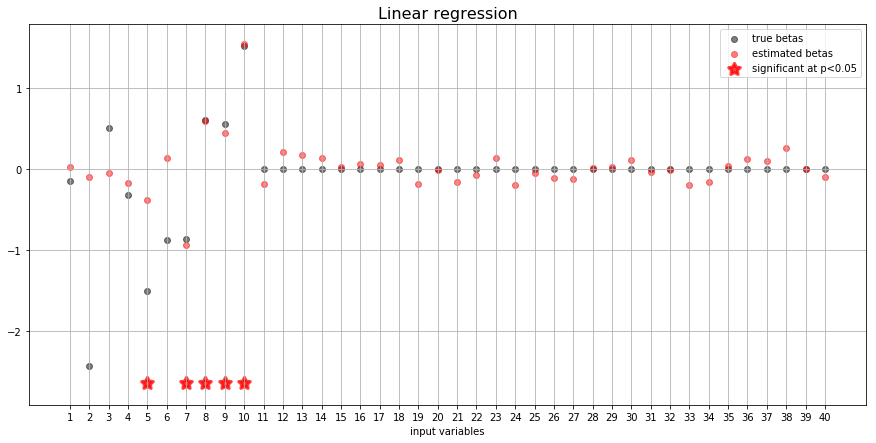

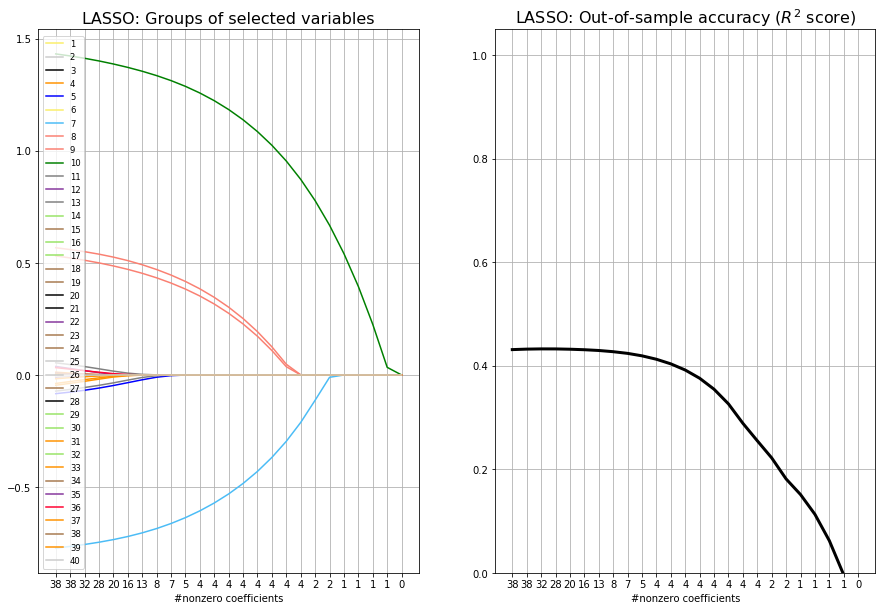

In [7]:
# abs / dataset: 10/40 relevant variables, including 5 pathological ones, linear ground truth, some noise
rs = np.random.RandomState(1)
n_samples = 1000
n_feat = 40
n_feat_relevant = 10
epsilon = rs.randn(n_samples)
true_coefs = rs.randn(n_feat)
true_coefs[n_feat_relevant:] = 0
X = rs.randn(n_samples, n_feat)

X_abs5 = X.copy()
X_abs5[:, 0:6] = np.abs(X_abs5[:, 0:6])  # introduce pathological transformation, NOT captured by ground-truth model
y = (true_coefs * X_abs5).sum(axis=1) + epsilon

# ordinary least squares
model = OLS(y, X)
res = model.fit()
lr_coefs = res.params
lr_pvalues = res.pvalues

# compute Lasso regularization paths
C_grid = np.logspace(-1.25, 0.25, 25)
coef_list, acc_list, nonzero_list = compute_Lasso_regpath(X, y, C_grid)

plot_lr(true_coefs, lr_coefs, lr_pvalues)
plot_regr_paths(coef_list, acc_list, nonzero_list, C_grid)
res.summary()

In [124]:
### observation: 1/5 path. variables are significant, the same 1/5 path. (?) variables are selected as predictive

alpha: 0.0100 acc: 0.88 active_coefs: 40
alpha: 0.0127 acc: 0.88 active_coefs: 40
alpha: 0.0162 acc: 0.88 active_coefs: 40
alpha: 0.0205 acc: 0.88 active_coefs: 40
alpha: 0.0261 acc: 0.88 active_coefs: 40
alpha: 0.0332 acc: 0.88 active_coefs: 39
alpha: 0.0422 acc: 0.88 active_coefs: 35
alpha: 0.0536 acc: 0.88 active_coefs: 29
alpha: 0.0681 acc: 0.88 active_coefs: 19
alpha: 0.0866 acc: 0.88 active_coefs: 16
alpha: 0.1101 acc: 0.87 active_coefs: 12
alpha: 0.1399 acc: 0.87 active_coefs: 10
alpha: 0.1778 acc: 0.86 active_coefs: 10
alpha: 0.2260 acc: 0.84 active_coefs: 8
alpha: 0.2873 acc: 0.82 active_coefs: 8
alpha: 0.3652 acc: 0.79 active_coefs: 8
alpha: 0.4642 acc: 0.74 active_coefs: 7
alpha: 0.5900 acc: 0.67 active_coefs: 7
alpha: 0.7499 acc: 0.58 active_coefs: 4
alpha: 0.9532 acc: 0.46 active_coefs: 4
alpha: 1.2115 acc: 0.28 active_coefs: 3
alpha: 1.5399 acc: 0.12 active_coefs: 2
alpha: 1.9573 acc: 0.00 active_coefs: 1
alpha: 2.4879 acc: -0.00 active_coefs: 0
alpha: 3.1623 acc: -0.00 a

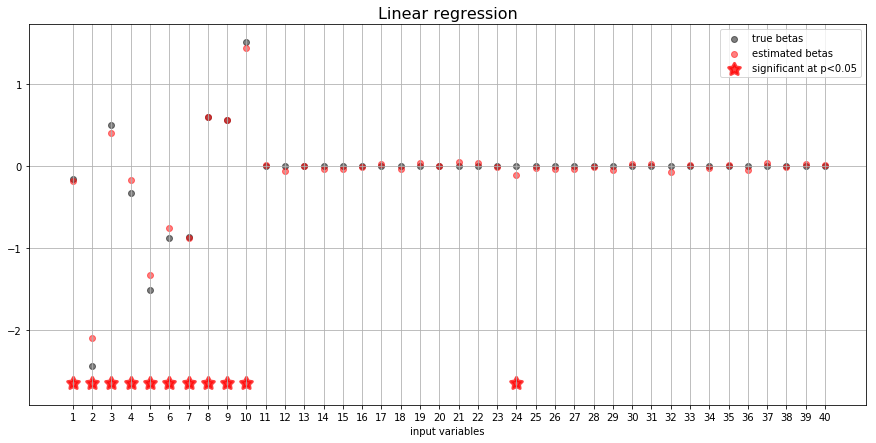

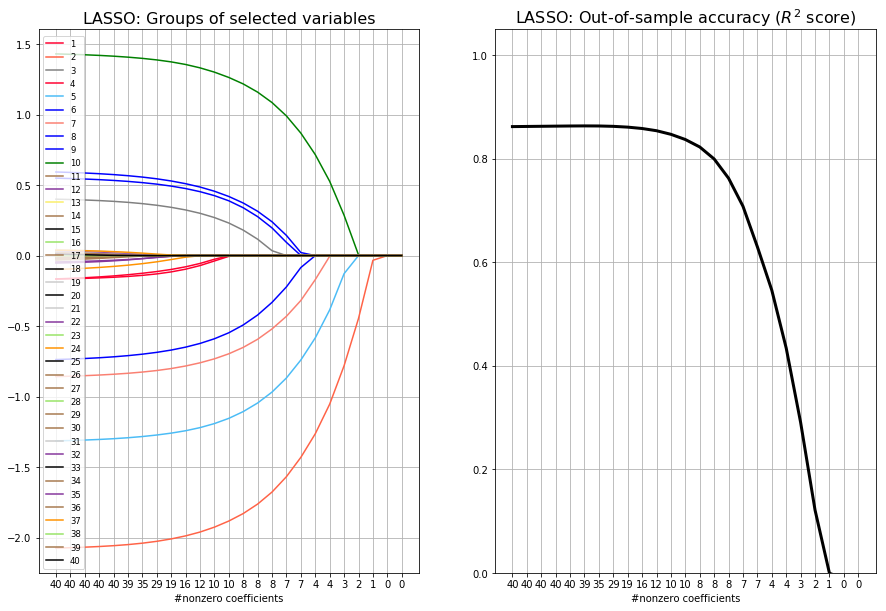

In [8]:
# square root / dataset: 10/40 relevant variables, including 5 pathological ones, linear ground truth, some noise
rs = np.random.RandomState(1)
n_samples = 1000
n_feat = 40
n_feat_relevant = 10
epsilon = rs.randn(n_samples)
true_coefs = rs.randn(n_feat)
true_coefs[n_feat_relevant:] = 0
X = rs.randn(n_samples, n_feat)

X_sqrt5 = X.copy()
signs = np.sign(X)
X_sqrt5[:, 0:6] = signs[:, 0:6] * np.sqrt(np.abs(X_sqrt5[:, 0:6]))  # introduce pathological transformation, NOT captured by ground-truth model
y = (true_coefs * X_sqrt5).sum(axis=1) + epsilon

# ordinary least squares
model = OLS(y, X)
res = model.fit()
lr_coefs = res.params
lr_pvalues = res.pvalues

# compute Lasso regularization paths
C_grid = np.logspace(-2, 0.5, 25)
coef_list, acc_list, nonzero_list = compute_Lasso_regpath(X, y, C_grid)

plot_lr(true_coefs, lr_coefs, lr_pvalues)
plot_regr_paths(coef_list, acc_list, nonzero_list, C_grid)

In [126]:
### observation: 5/5 path. variables are significant, the same 5/5 path. (?) variables are selected as predictive

alpha: 0.0100 acc: 0.13 active_coefs: 40
alpha: 0.0127 acc: 0.13 active_coefs: 40
alpha: 0.0162 acc: 0.13 active_coefs: 40
alpha: 0.0205 acc: 0.13 active_coefs: 40
alpha: 0.0261 acc: 0.13 active_coefs: 40
alpha: 0.0332 acc: 0.13 active_coefs: 40
alpha: 0.0422 acc: 0.13 active_coefs: 40
alpha: 0.0536 acc: 0.14 active_coefs: 40
alpha: 0.0681 acc: 0.14 active_coefs: 40
alpha: 0.0866 acc: 0.14 active_coefs: 40
alpha: 0.1101 acc: 0.14 active_coefs: 40
alpha: 0.1399 acc: 0.15 active_coefs: 38
alpha: 0.1778 acc: 0.16 active_coefs: 29
alpha: 0.2260 acc: 0.15 active_coefs: 16
alpha: 0.2873 acc: 0.15 active_coefs: 13
alpha: 0.3652 acc: 0.15 active_coefs: 8
alpha: 0.4642 acc: 0.14 active_coefs: 5
alpha: 0.5900 acc: 0.13 active_coefs: 4
alpha: 0.7499 acc: 0.12 active_coefs: 3
alpha: 0.9532 acc: 0.09 active_coefs: 2
alpha: 1.2115 acc: 0.06 active_coefs: 1
alpha: 1.5399 acc: 0.01 active_coefs: 1
alpha: 1.9573 acc: -0.00 active_coefs: 0
alpha: 2.4879 acc: -0.00 active_coefs: 0
alpha: 3.1623 acc: -0.0

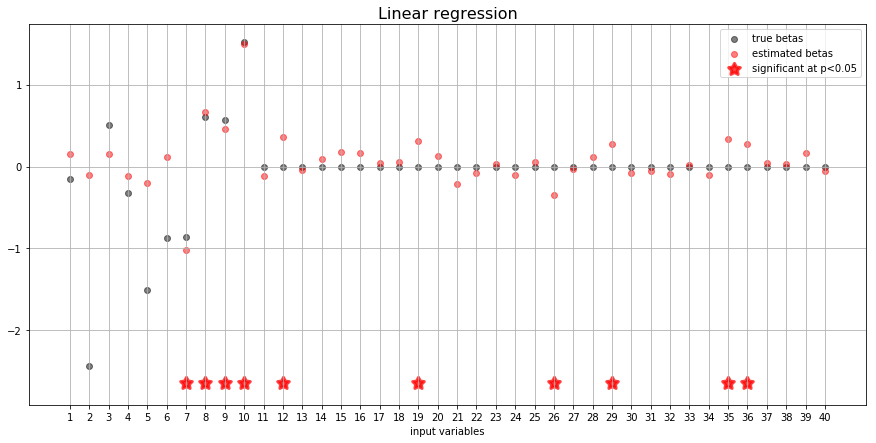

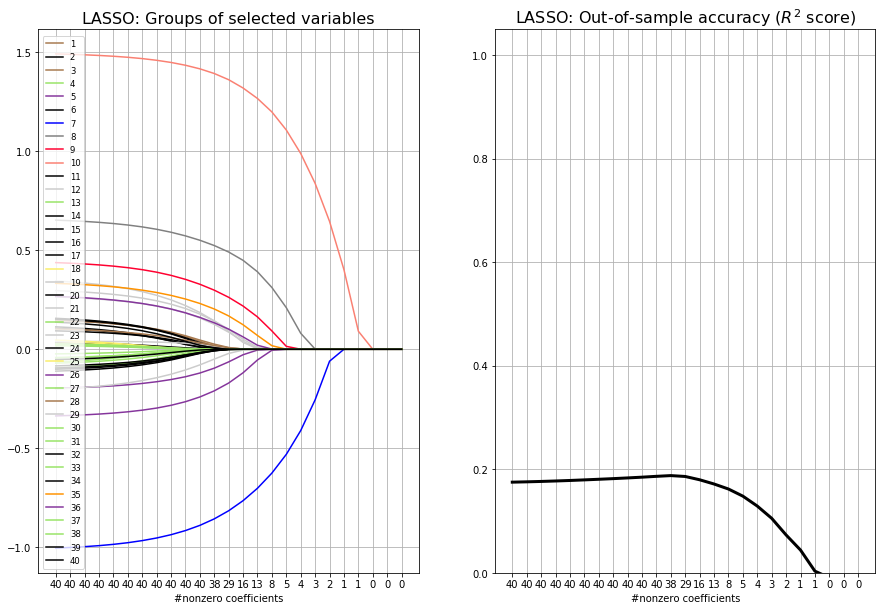

In [127]:
# logn / dataset: 10/40 relevant variables, including 5 pathological ones, linear ground truth, some noise
rs = np.random.RandomState(1)
n_samples = 1000
n_feat = 40
n_feat_relevant = 10
epsilon = rs.randn(n_samples)
true_coefs = rs.randn(n_feat)
true_coefs[n_feat_relevant:] = 0
X = rs.randn(n_samples, n_feat)

X_log5 = X.copy()
signs = np.sign(X)
# Bertrand: no sign update
# Bertrand: rather log (X + constant); such as constant=4
X_log5[:, 0:6] = signs[:, 0:6] * np.log(np.abs(X_log5[:, 0:6]))  # introduce pathological transformation, NOT captured by ground-truth model
y = (true_coefs * X_log5).sum(axis=1) + epsilon

# ordinary least squares
model = OLS(y, X)
res = model.fit()
lr_coefs = res.params
lr_pvalues = res.pvalues

# compute Lasso regularization paths
C_grid = np.logspace(-2, 0.5, 25)
coef_list, acc_list, nonzero_list = compute_Lasso_regpath(X, y, C_grid)

plot_lr(true_coefs, lr_coefs, lr_pvalues)
plot_regr_paths(coef_list, acc_list, nonzero_list, C_grid)

### observation: 0/5 path. variables are significant, the same 1/5 path. variables are selected as predictive -> 

alpha: 0.0010 acc: 0.70 active_coefs: 40
alpha: 0.0015 acc: 0.70 active_coefs: 40
alpha: 0.0022 acc: 0.70 active_coefs: 40
alpha: 0.0032 acc: 0.70 active_coefs: 40
alpha: 0.0046 acc: 0.70 active_coefs: 40
alpha: 0.0068 acc: 0.70 active_coefs: 40
alpha: 0.0100 acc: 0.70 active_coefs: 40
alpha: 0.0147 acc: 0.70 active_coefs: 40
alpha: 0.0215 acc: 0.70 active_coefs: 40
alpha: 0.0316 acc: 0.70 active_coefs: 40
alpha: 0.0464 acc: 0.71 active_coefs: 40
alpha: 0.0681 acc: 0.71 active_coefs: 40
alpha: 0.1000 acc: 0.71 active_coefs: 40
alpha: 0.1468 acc: 0.71 active_coefs: 37
alpha: 0.2154 acc: 0.72 active_coefs: 25
alpha: 0.3162 acc: 0.72 active_coefs: 15
alpha: 0.4642 acc: 0.71 active_coefs: 9
alpha: 0.6813 acc: 0.67 active_coefs: 8
alpha: 1.0000 acc: 0.62 active_coefs: 4
alpha: 1.4678 acc: 0.51 active_coefs: 4
alpha: 2.1544 acc: 0.39 active_coefs: 2
alpha: 3.1623 acc: 0.17 active_coefs: 2
alpha: 4.6416 acc: -0.00 active_coefs: 0
alpha: 6.8129 acc: -0.00 active_coefs: 0
alpha: 10.0000 acc: -0

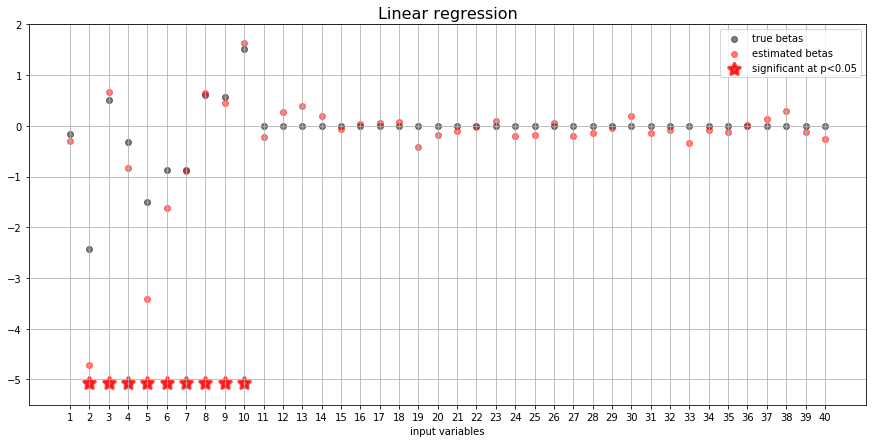

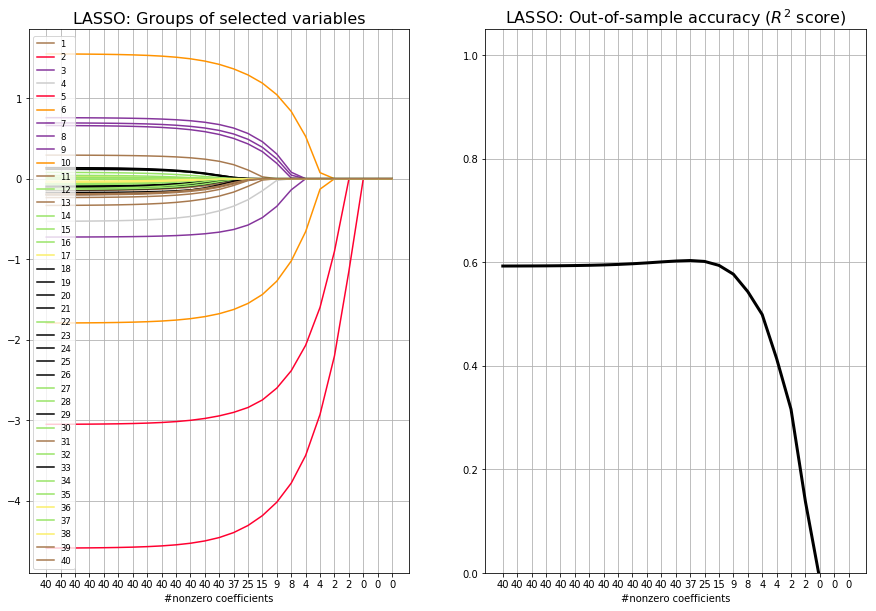

In [138]:
# exp / dataset: 10/40 relevant variables, including 5 pathological ones, linear ground truth, some noise
# only monotone transformation
rs = np.random.RandomState(1)
n_samples = 1000
n_feat = 40
n_feat_relevant = 10
epsilon = rs.randn(n_samples)
true_coefs = rs.randn(n_feat)
true_coefs[n_feat_relevant:] = 0
X = rs.randn(n_samples, n_feat)

X_exp = X.copy()
signs = np.sign(X)
X_exp[:, 0:6] = signs[:, 0:6] * np.exp(X_exp[:, 0:6])  # introduce pathological transformation, NOT captured by ground-truth model
y = (true_coefs * X_exp).sum(axis=1) + epsilon

# ordinary least squares
model = OLS(y, X)
res = model.fit()
lr_coefs = res.params
lr_pvalues = res.pvalues

# compute Lasso regularization paths
C_grid = np.logspace(-3, 1, 25)
coef_list, acc_list, nonzero_list = compute_Lasso_regpath(X, y, C_grid)

plot_lr(true_coefs, lr_coefs, lr_pvalues)
plot_regr_paths(coef_list, acc_list, nonzero_list, C_grid)

### observation: 4/5 path. variables are significant, the ?/5 path. variables are selected as predictive

alpha: 0.0100 acc: -0.13 active_coefs: 40
alpha: 0.0140 acc: -0.13 active_coefs: 40
alpha: 0.0196 acc: -0.13 active_coefs: 40
alpha: 0.0274 acc: -0.13 active_coefs: 40
alpha: 0.0383 acc: -0.13 active_coefs: 40
alpha: 0.0536 acc: -0.13 active_coefs: 40
alpha: 0.0750 acc: -0.13 active_coefs: 40
alpha: 0.1049 acc: -0.13 active_coefs: 40
alpha: 0.1468 acc: -0.13 active_coefs: 40
alpha: 0.2054 acc: -0.13 active_coefs: 40
alpha: 0.2873 acc: -0.12 active_coefs: 40
alpha: 0.4019 acc: -0.12 active_coefs: 40
alpha: 0.5623 acc: -0.12 active_coefs: 40
alpha: 0.7867 acc: -0.11 active_coefs: 40
alpha: 1.1007 acc: -0.11 active_coefs: 40
alpha: 1.5399 acc: -0.10 active_coefs: 40
alpha: 2.1544 acc: -0.09 active_coefs: 40
alpha: 3.0142 acc: -0.08 active_coefs: 40
alpha: 4.2170 acc: -0.06 active_coefs: 33
alpha: 5.8997 acc: -0.05 active_coefs: 28
alpha: 8.2540 acc: -0.04 active_coefs: 16
alpha: 11.5478 acc: -0.02 active_coefs: 7
alpha: 16.1560 acc: -0.02 active_coefs: 0
alpha: 22.6030 acc: -0.02 active_c

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.9307
Date:                Wed, 21 Mar 2018   Prob (F-statistic):              0.595
Time:                        17:02:20   Log-Likelihood:                -6580.2
No. Observations:                1000   AIC:                         1.324e+04
Df Residuals:                     960   BIC:                         1.344e+04
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.0715      5.740      0.361      0.718      -9.193      13.336
x2            -3.7311      5.726     -0.652      0.515     -14.967       7.505
x3            -4.4272      5.809     -0.762      0.446     -15.827       6.972
x4             0.3815      5.937      0.064      0.949     -11.269      12.032
x5             2.3155      5.627      0.412      0.681      -8.727      13.358
x6            -3.7044      5.876     -0.630      0.529     -15.237       7.828
x7            10.3631      5.682      1.824      0.069      -0.788      21.515
x8            -7.6559      5.915     -1.294      0.196     -19.263       3.951
x9            -5.9346      5.674     -1.046      0.296     -17.069       5.200
x10            3.5776      5.595      0.639      0.523      -7.402      14.558
x11            0.6019      5.618      0.107      0.915     -10.424      11.628
x12           -9.1506      5.884     -1.555      0.120     -20.699       2.397
x13            4.5792      5.763      0.795      0.427      -6.730      15.889
x14           -3.5027      5.858     -0.598      0.550     -14.999       7.994
x15           -1.6934      5.868     -0.289      0.773     -13.210       9.823
x16           -9.6225      5.905     -1.630      0.104     -21.211       1.966
x17            5.2940      5.831      0.908      0.364      -6.149      16.737
x18           -0.7292      5.862     -0.124      0.901     -12.233      10.774
x19          -10.7046      6.054     -1.768      0.077     -22.586       1.177
x20           -1.2465      5.694     -0.219      0.827     -12.421       9.928
x21           10.9041      5.755      1.895      0.058      -0.390      22.198
x22           -2.1189      5.661     -0.374      0.708     -13.228       8.991
x23           -4.4705      5.652     -0.791      0.429     -15.562       6.621
x24            6.4719      6.092      1.062      0.288      -5.483      18.426
x25            6.2971      5.846      1.077      0.282      -5.175      17.769
x26            7.0320      5.755      1.222      0.222      -4.261      18.325
x27           -1.3506      5.724     -0.236      0.814     -12.584       9.883
x28           -1.7445      5.751     -0.303      0.762     -13.031       9.542
x29           -5.9931      5.777     -1.037      0.300     -17.330       5.344
x30            2.3008      5.498      0.418      0.676      -8.489      13.090
x31          -10.1401      5.677     -1.786      0.074     -21.280       1.000
x32           -4.5452      5.658     -0.803      0.422     -15.649       6.558
x33           -1.5954      5.679     -0.281      0.779     -12.741       9.550
x34            3.7306      5.704      0.654      0.513      -7.463      14.924
x35           -1.6313      5.601     -0.291      0.771     -12.622       9.360
x36           -7.3935      5.718     -1.293      0.196     -18.614       3.827
x3

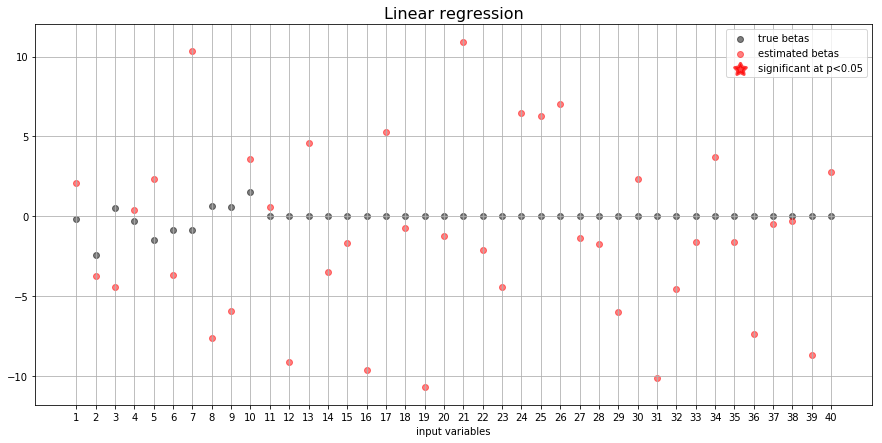

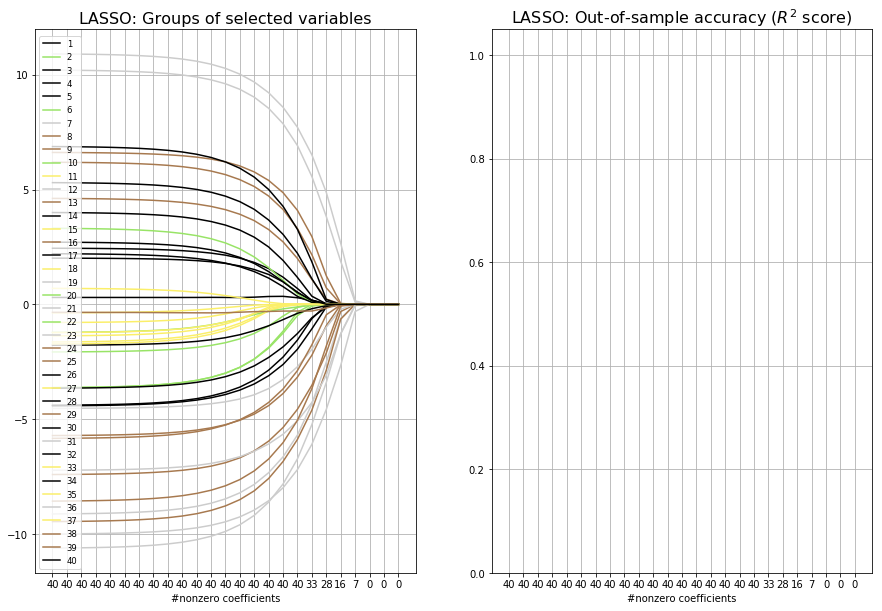

In [9]:
# 1/x / dataset: 10/40 relevant variables, including 5 pathological ones, linear ground truth, some noise
# opposite effect of log roughly; small values become gigantic
rs = np.random.RandomState(1)
n_samples = 1000
n_feat = 40
n_feat_relevant = 10
epsilon = rs.randn(n_samples)
true_coefs = rs.randn(n_feat)
true_coefs[n_feat_relevant:] = 0
X = rs.randn(n_samples, n_feat)

X_inv = X.copy()
X_inv[:, 0:6] = 1. / X_inv[:, 0:6]  # introduce pathological transformation, NOT captured by ground-truth model
y = (true_coefs * X_inv).sum(axis=1) + epsilon

# ordinary least squares
model = OLS(y, X)
res = model.fit()
lr_coefs = res.params
lr_pvalues = res.pvalues

# compute Lasso regularization paths
C_grid = np.logspace(-2, 1.5, 25)
coef_list, acc_list, nonzero_list = compute_Lasso_regpath(X, y, C_grid)

plot_lr(true_coefs, lr_coefs, lr_pvalues)
plot_regr_paths(coef_list, acc_list, nonzero_list, C_grid)
res.summary()

### observation: 0/5 path. variables are significant, the 0/5 path. variables are selected as predictive -> B: un peu extreme

# __Polynomial transformations 1000 samples, 40 variables, error = N(0, 1)__

alpha: 0.0100 acc: 0.10 active_coefs: 40
alpha: 0.0140 acc: 0.10 active_coefs: 40
alpha: 0.0196 acc: 0.10 active_coefs: 40
alpha: 0.0274 acc: 0.11 active_coefs: 40
alpha: 0.0383 acc: 0.11 active_coefs: 40
alpha: 0.0536 acc: 0.12 active_coefs: 40
alpha: 0.0750 acc: 0.12 active_coefs: 40
alpha: 0.1049 acc: 0.13 active_coefs: 40
alpha: 0.1468 acc: 0.14 active_coefs: 35
alpha: 0.2054 acc: 0.14 active_coefs: 21
alpha: 0.2873 acc: 0.15 active_coefs: 10
alpha: 0.4019 acc: 0.15 active_coefs: 7
alpha: 0.5623 acc: 0.13 active_coefs: 4
alpha: 0.7867 acc: 0.10 active_coefs: 2
alpha: 1.1007 acc: 0.05 active_coefs: 1
alpha: 1.5399 acc: -0.03 active_coefs: 1
alpha: 2.1544 acc: -0.03 active_coefs: 0
alpha: 3.0142 acc: -0.03 active_coefs: 0
alpha: 4.2170 acc: -0.03 active_coefs: 0
alpha: 5.8997 acc: -0.03 active_coefs: 0
alpha: 8.2540 acc: -0.03 active_coefs: 0
alpha: 11.5478 acc: -0.03 active_coefs: 0
alpha: 16.1560 acc: -0.03 active_coefs: 0
alpha: 22.6030 acc: -0.03 active_coefs: 0
alpha: 31.6228 ac

array([  8.54744936e-01,   3.88386715e-01,   3.80757351e-01,
         3.19273365e-01,   3.14664878e-03,   6.69390379e-01,
         2.18009324e-05,   3.68385394e-03,   2.10809670e-02,
         2.18873540e-14,   1.11389683e-01,   1.55424808e-01,
         1.32482885e-01,   4.92392581e-01,   7.68830230e-01,
         6.54066690e-01,   6.36484162e-01,   6.82338590e-01,
         1.62147425e-01,   9.75748871e-01,   3.81642260e-01,
         4.32517892e-01,   5.58140224e-01,   3.52440185e-01,
         8.20170189e-01,   6.72241755e-01,   3.60197330e-01,
         5.77080453e-01,   7.03229719e-01,   6.76245156e-01,
         4.66727942e-01,   9.89184958e-01,   4.95286053e-02,
         6.02288463e-01,   9.56662478e-01,   3.97247000e-01,
         4.67505455e-01,   9.04093994e-02,   9.13567393e-01,
         2.94185068e-01])

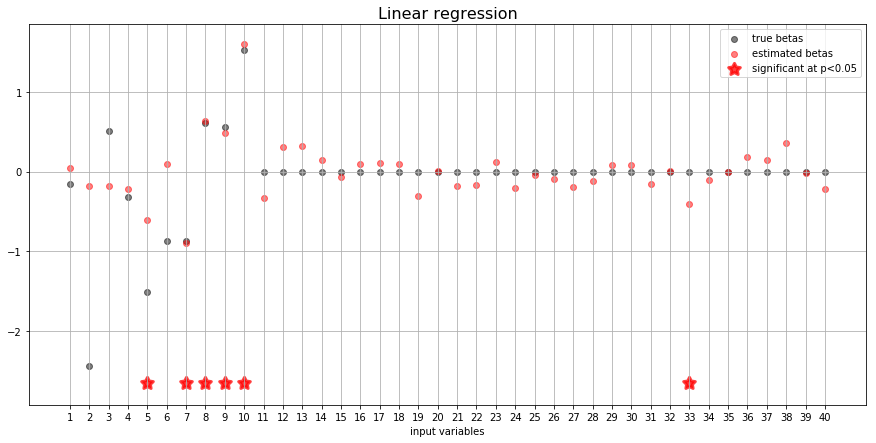

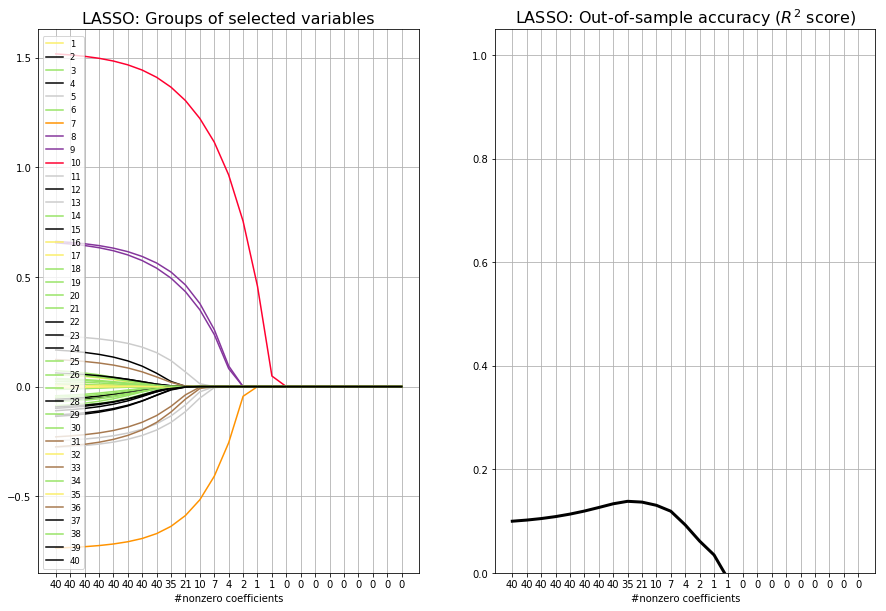

In [11]:
# x^2 / dataset: 10/40 relevant variables, including 5 pathological ones, linear ground truth, some noise
# cube -> keep monotony; otherwise not -> 
rs = np.random.RandomState(1)
n_samples = 1000
n_feat = 40
n_feat_relevant = 10
epsilon = rs.randn(n_samples)
true_coefs = rs.randn(n_feat)
true_coefs[n_feat_relevant:] = 0
X = rs.randn(n_samples, n_feat)

X_2 = X.copy()
X_2[:, 0:6] = np.square(X_2[:, 0:6])  # introduce pathological transformation, NOT captured by ground-truth model
y = (true_coefs * X_2).sum(axis=1) + epsilon

# ordinary least squares
model = OLS(y, X)
res = model.fit()
lr_coefs = res.params
lr_pvalues = res.pvalues

# compute Lasso regularization paths
C_grid = np.logspace(-2, 1.5, 25)
coef_list, acc_list, nonzero_list = compute_Lasso_regpath(X, y, C_grid)

plot_lr(true_coefs, lr_coefs, lr_pvalues)
plot_regr_paths(coef_list, acc_list, nonzero_list, C_grid)
res.summary()
lr_pvalues

### observation: 1/5 path. variables are significant, the same 1/5 path. variables are selected as predictive

alpha: 0.0100 acc: 0.70 active_coefs: 40
alpha: 0.0140 acc: 0.70 active_coefs: 40
alpha: 0.0196 acc: 0.70 active_coefs: 40
alpha: 0.0274 acc: 0.70 active_coefs: 40
alpha: 0.0383 acc: 0.70 active_coefs: 40
alpha: 0.0536 acc: 0.70 active_coefs: 40
alpha: 0.0750 acc: 0.71 active_coefs: 40
alpha: 0.1049 acc: 0.71 active_coefs: 40
alpha: 0.1468 acc: 0.71 active_coefs: 40
alpha: 0.2054 acc: 0.71 active_coefs: 37
alpha: 0.2873 acc: 0.71 active_coefs: 33
alpha: 0.4019 acc: 0.71 active_coefs: 24
alpha: 0.5623 acc: 0.70 active_coefs: 12
alpha: 0.7867 acc: 0.68 active_coefs: 8
alpha: 1.1007 acc: 0.64 active_coefs: 7
alpha: 1.5399 acc: 0.57 active_coefs: 4
alpha: 2.1544 acc: 0.50 active_coefs: 3
alpha: 3.0142 acc: 0.41 active_coefs: 2
alpha: 4.2170 acc: 0.23 active_coefs: 2
alpha: 5.8997 acc: 0.08 active_coefs: 1
alpha: 8.2540 acc: -0.00 active_coefs: 0
alpha: 11.5478 acc: -0.00 active_coefs: 0
alpha: 16.1560 acc: -0.00 active_coefs: 0
alpha: 22.6030 acc: -0.00 active_coefs: 0
alpha: 31.6228 acc: 

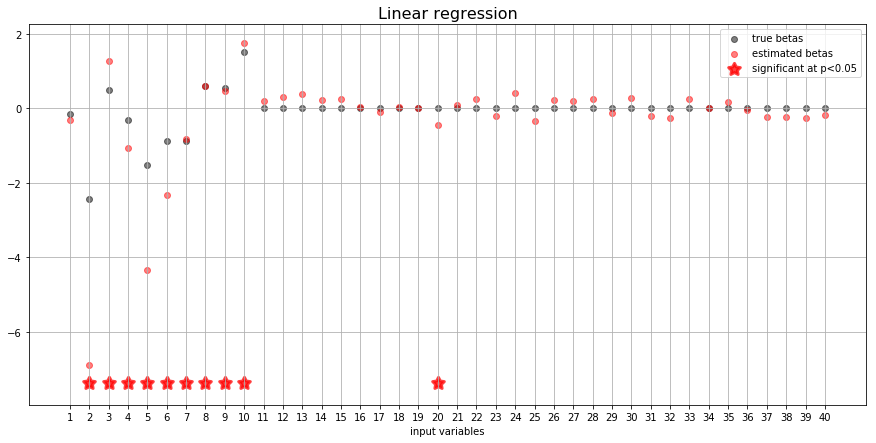

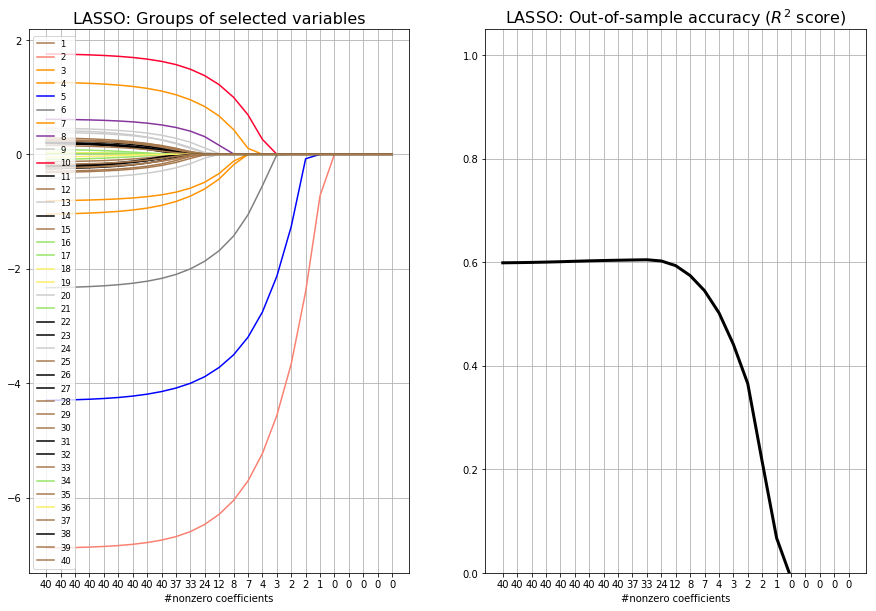

In [175]:
# x^3 / dataset: 10/40 relevant variables, including 5 pathological ones, linear ground truth, some noise
rs = np.random.RandomState(1)
n_samples = 1000
n_feat = 40
n_feat_relevant = 10
epsilon = rs.randn(n_samples)
true_coefs = rs.randn(n_feat)
true_coefs[n_feat_relevant:] = 0
X = rs.randn(n_samples, n_feat)

X_3 = X.copy()
X_3[:, 0:6] = X_3[:, 0:6]**3  # introduce pathological transformation, NOT captured by ground-truth model
y = (true_coefs * X_3).sum(axis=1) + epsilon

# ordinary least squares
model = OLS(y, X)
res = model.fit()
lr_coefs = res.params
lr_pvalues = res.pvalues

# compute Lasso regularization paths
C_grid = np.logspace(-2, 1.5, 25)
coef_list, acc_list, nonzero_list = compute_Lasso_regpath(X, y, C_grid)

plot_lr(true_coefs, lr_coefs, lr_pvalues)
plot_regr_paths(coef_list, acc_list, nonzero_list, C_grid)

In [ ]:
### observation: 4/5 path. variables are significant, the same 4/5 path. variables are selected as predictive

alpha: 0.1000 acc: -0.13 active_coefs: 40
alpha: 0.1212 acc: -0.13 active_coefs: 40
alpha: 0.1468 acc: -0.12 active_coefs: 40
alpha: 0.1778 acc: -0.12 active_coefs: 40
alpha: 0.2154 acc: -0.11 active_coefs: 40
alpha: 0.2610 acc: -0.11 active_coefs: 40
alpha: 0.3162 acc: -0.10 active_coefs: 40
alpha: 0.3831 acc: -0.09 active_coefs: 40
alpha: 0.4642 acc: -0.08 active_coefs: 40
alpha: 0.5623 acc: -0.07 active_coefs: 40
alpha: 0.6813 acc: -0.06 active_coefs: 39
alpha: 0.8254 acc: -0.05 active_coefs: 37
alpha: 1.0000 acc: -0.04 active_coefs: 33
alpha: 1.2115 acc: -0.02 active_coefs: 25
alpha: 1.4678 acc: -0.01 active_coefs: 17
alpha: 1.7783 acc: -0.00 active_coefs: 9
alpha: 2.1544 acc: -0.00 active_coefs: 3
alpha: 2.6102 acc: -0.00 active_coefs: 1
alpha: 3.1623 acc: -0.00 active_coefs: 0
alpha: 3.8312 acc: -0.00 active_coefs: 0
alpha: 4.6416 acc: -0.00 active_coefs: 0
alpha: 5.6234 acc: -0.00 active_coefs: 0
alpha: 6.8129 acc: -0.00 active_coefs: 0
alpha: 8.2540 acc: -0.00 active_coefs: 0
a

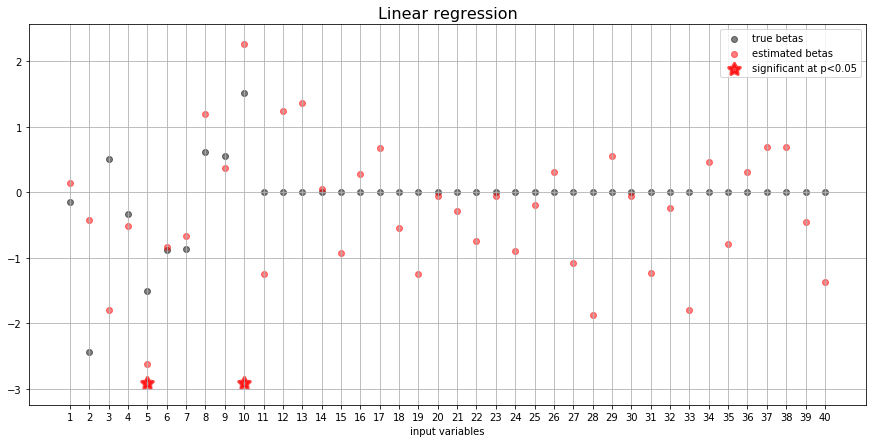

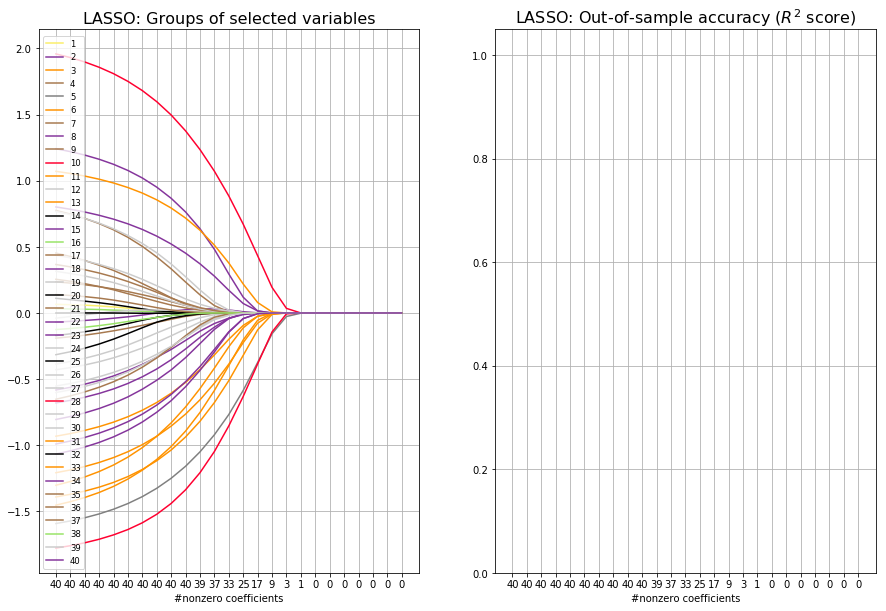

In [178]:
# x^4 / dataset: 10/40 relevant variables, including 5 pathological ones, linear ground truth, some noise
rs = np.random.RandomState(1)
n_samples = 1000
n_feat = 40
n_feat_relevant = 10
epsilon = rs.randn(n_samples)
true_coefs = rs.randn(n_feat)
true_coefs[n_feat_relevant:] = 0
X = rs.randn(n_samples, n_feat)

X_4 = X.copy()
X_4[:, 0:6] = X_4[:, 0:6]**4  # introduce pathological transformation, NOT captured by ground-truth model
y = (true_coefs * X_4).sum(axis=1) + epsilon

# ordinary least squares
model = OLS(y, X)
res = model.fit()
lr_coefs = res.params
lr_pvalues = res.pvalues

# compute Lasso regularization paths
C_grid = np.logspace(-1, 1.0, 25)
coef_list, acc_list, nonzero_list = compute_Lasso_regpath(X, y, C_grid)

plot_lr(true_coefs, lr_coefs, lr_pvalues)
plot_regr_paths(coef_list, acc_list, nonzero_list, C_grid)

### observation: 1/5 path. variables are significant, the same 1/5 path. variables are selected as predictive + coefficients for other 4/5 relevant variables are messed up

alpha: 0.1000 acc: 0.28 active_coefs: 40
alpha: 0.1334 acc: 0.28 active_coefs: 40
alpha: 0.1778 acc: 0.29 active_coefs: 40
alpha: 0.2371 acc: 0.29 active_coefs: 40
alpha: 0.3162 acc: 0.29 active_coefs: 40
alpha: 0.4217 acc: 0.30 active_coefs: 40
alpha: 0.5623 acc: 0.30 active_coefs: 40
alpha: 0.7499 acc: 0.31 active_coefs: 40
alpha: 1.0000 acc: 0.31 active_coefs: 40
alpha: 1.3335 acc: 0.32 active_coefs: 40
alpha: 1.7783 acc: 0.33 active_coefs: 36
alpha: 2.3714 acc: 0.34 active_coefs: 33
alpha: 3.1623 acc: 0.35 active_coefs: 25
alpha: 4.2170 acc: 0.35 active_coefs: 11
alpha: 5.6234 acc: 0.33 active_coefs: 6
alpha: 7.4989 acc: 0.30 active_coefs: 3
alpha: 10.0000 acc: 0.26 active_coefs: 3
alpha: 13.3352 acc: 0.22 active_coefs: 2
alpha: 17.7828 acc: 0.15 active_coefs: 2
alpha: 23.7137 acc: 0.10 active_coefs: 1
alpha: 31.6228 acc: -0.00 active_coefs: 1
alpha: 42.1697 acc: -0.00 active_coefs: 0
alpha: 56.2341 acc: -0.00 active_coefs: 0
alpha: 74.9894 acc: -0.00 active_coefs: 0
alpha: 100.000

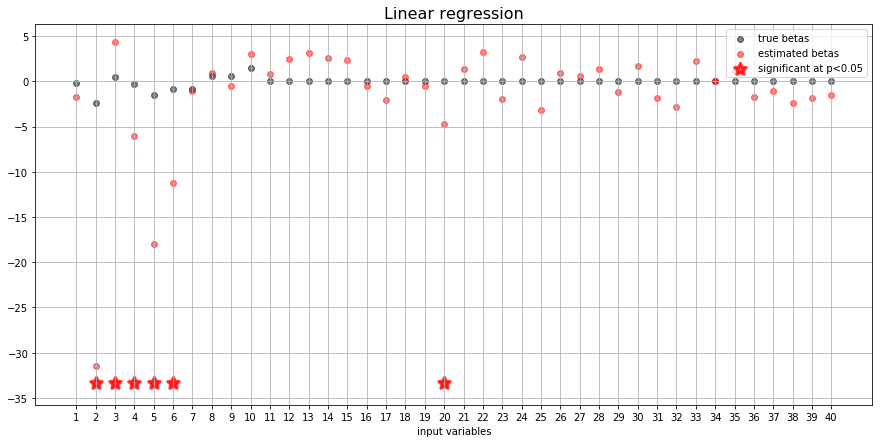

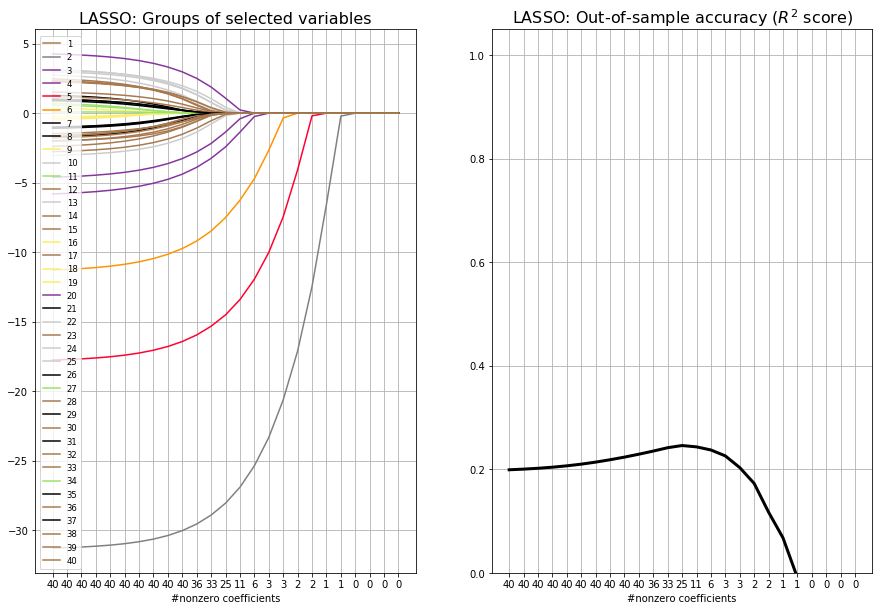

In [181]:
# x^5 / dataset: 10/40 relevant variables, including 5 pathological ones, linear ground truth, some noise
rs = np.random.RandomState(1)
n_samples = 1000
n_feat = 40
n_feat_relevant = 10
epsilon = rs.randn(n_samples)
true_coefs = rs.randn(n_feat)
true_coefs[n_feat_relevant:] = 0
X = rs.randn(n_samples, n_feat)

X_5 = X.copy()
X_5[:, 0:6] = X_5[:, 0:6]**5  # introduce pathological transformation, NOT captured by ground-truth model
y = (true_coefs * X_5).sum(axis=1) + epsilon

# ordinary least squares
model = OLS(y, X)
res = model.fit()
lr_coefs = res.params
lr_pvalues = res.pvalues

# compute Lasso regularization paths
C_grid = np.logspace(-1, 2, 25)
coef_list, acc_list, nonzero_list = compute_Lasso_regpath(X, y, C_grid)

plot_lr(true_coefs, lr_coefs, lr_pvalues)
plot_regr_paths(coef_list, acc_list, nonzero_list, C_grid)

### observation: similar to X^3 4/5 path. variables are significant, the same 4/5 path. variables are selected as predictive; other than X^3 but similar to X^4 coefficients for other 4/5 relevant variables are messed up

# Multicollinearity with correct model, 1000 samples, 40 variables, error = N(0, 1)__

alpha: 0.0100 acc: 0.93 active_coefs: 40
alpha: 0.0133 acc: 0.93 active_coefs: 40
alpha: 0.0178 acc: 0.93 active_coefs: 40
alpha: 0.0237 acc: 0.93 active_coefs: 39
alpha: 0.0316 acc: 0.93 active_coefs: 36
alpha: 0.0422 acc: 0.93 active_coefs: 29
alpha: 0.0562 acc: 0.92 active_coefs: 21
alpha: 0.0750 acc: 0.92 active_coefs: 15
alpha: 0.1000 acc: 0.91 active_coefs: 12
alpha: 0.1334 acc: 0.90 active_coefs: 9
alpha: 0.1778 acc: 0.89 active_coefs: 9
alpha: 0.2371 acc: 0.87 active_coefs: 8
alpha: 0.3162 acc: 0.85 active_coefs: 7
alpha: 0.4217 acc: 0.81 active_coefs: 7
alpha: 0.5623 acc: 0.73 active_coefs: 7
alpha: 0.7499 acc: 0.64 active_coefs: 5
alpha: 1.0000 acc: 0.51 active_coefs: 3
alpha: 1.3335 acc: 0.30 active_coefs: 3
alpha: 1.7783 acc: 0.10 active_coefs: 2
alpha: 2.3714 acc: -0.00 active_coefs: 0
alpha: 3.1623 acc: -0.00 active_coefs: 0
alpha: 4.2170 acc: -0.00 active_coefs: 0
alpha: 5.6234 acc: -0.00 active_coefs: 0
alpha: 7.4989 acc: -0.00 active_coefs: 0
alpha: 10.0000 acc: -0.00 

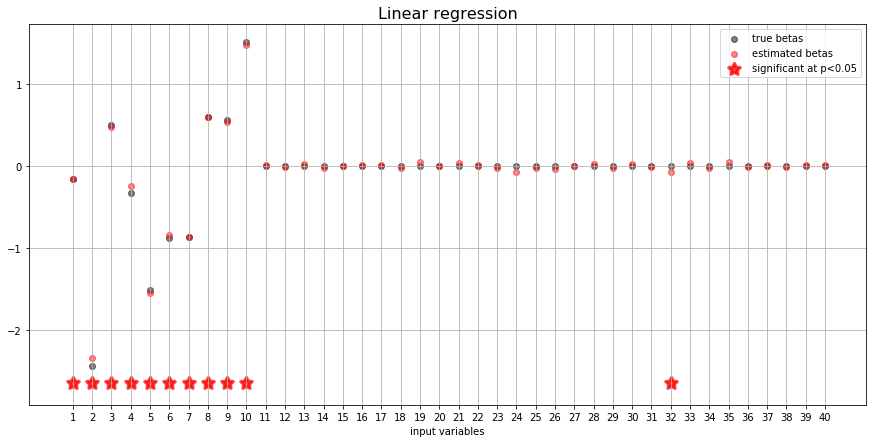

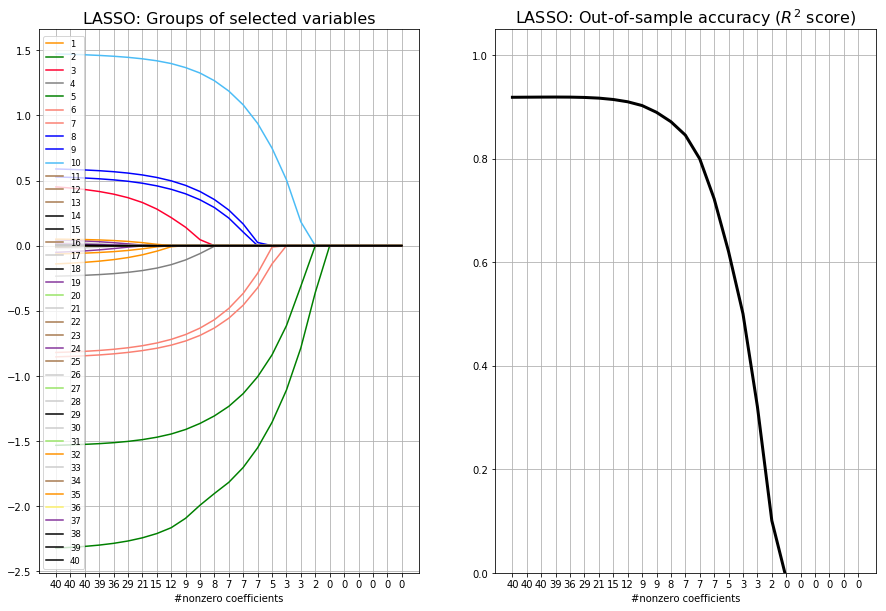

In [199]:
# 3 correlated vars at ~50% / dataset: 10/40 relevant variables, linear ground truth, some noise
rs = np.random.RandomState(1)
n_samples = 1000
n_feat = 40
n_feat_relevant = 10
epsilon = rs.randn(n_samples)
true_coefs = rs.randn(n_feat)
true_coefs[n_feat_relevant:] = 0
X = rs.randn(n_samples, n_feat)

n_corr_feat = 3
cov = np.ones((n_corr_feat, n_corr_feat)) * .5
cov[np.diag_indices(n_corr_feat)] = 1

X_corr = rs.multivariate_normal(mean=np.zeros((n_corr_feat)), cov=cov, size=n_samples)
X[:, 0:n_corr_feat] = X_corr
y = (true_coefs * X).sum(axis=1) + epsilon

# ordinary least squares
model = OLS(y, X)
res = model.fit()
lr_coefs = res.params
lr_pvalues = res.pvalues

# compute Lasso regularization paths
C_grid = np.logspace(-2, 1, 25)
coef_list, acc_list, nonzero_list = compute_Lasso_regpath(X, y, C_grid)

plot_lr(true_coefs, lr_coefs, lr_pvalues)
plot_regr_paths(coef_list, acc_list, nonzero_list, C_grid)

In [194]:
### observation: 10/10 variables are significant, the 2/3 corr. variables are selected as predictive

alpha: 0.0100 acc: 0.94 active_coefs: 40
alpha: 0.0133 acc: 0.94 active_coefs: 40
alpha: 0.0178 acc: 0.94 active_coefs: 40
alpha: 0.0237 acc: 0.94 active_coefs: 39
alpha: 0.0316 acc: 0.94 active_coefs: 35
alpha: 0.0422 acc: 0.94 active_coefs: 28
alpha: 0.0562 acc: 0.94 active_coefs: 19
alpha: 0.0750 acc: 0.94 active_coefs: 14
alpha: 0.1000 acc: 0.94 active_coefs: 12
alpha: 0.1334 acc: 0.93 active_coefs: 10
alpha: 0.1778 acc: 0.92 active_coefs: 10
alpha: 0.2371 acc: 0.91 active_coefs: 9
alpha: 0.3162 acc: 0.89 active_coefs: 8
alpha: 0.4217 acc: 0.85 active_coefs: 8
alpha: 0.5623 acc: 0.79 active_coefs: 8
alpha: 0.7499 acc: 0.71 active_coefs: 6
alpha: 1.0000 acc: 0.62 active_coefs: 4
alpha: 1.3335 acc: 0.47 active_coefs: 3
alpha: 1.7783 acc: 0.34 active_coefs: 2
alpha: 2.3714 acc: 0.20 active_coefs: 1
alpha: 3.1623 acc: 0.01 active_coefs: 1
alpha: 4.2170 acc: -0.00 active_coefs: 0
alpha: 5.6234 acc: -0.00 active_coefs: 0
alpha: 7.4989 acc: -0.00 active_coefs: 0
alpha: 10.0000 acc: -0.00 

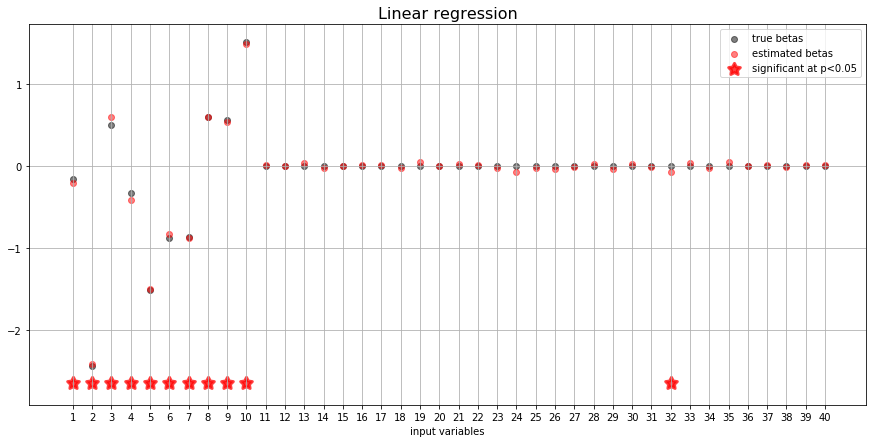

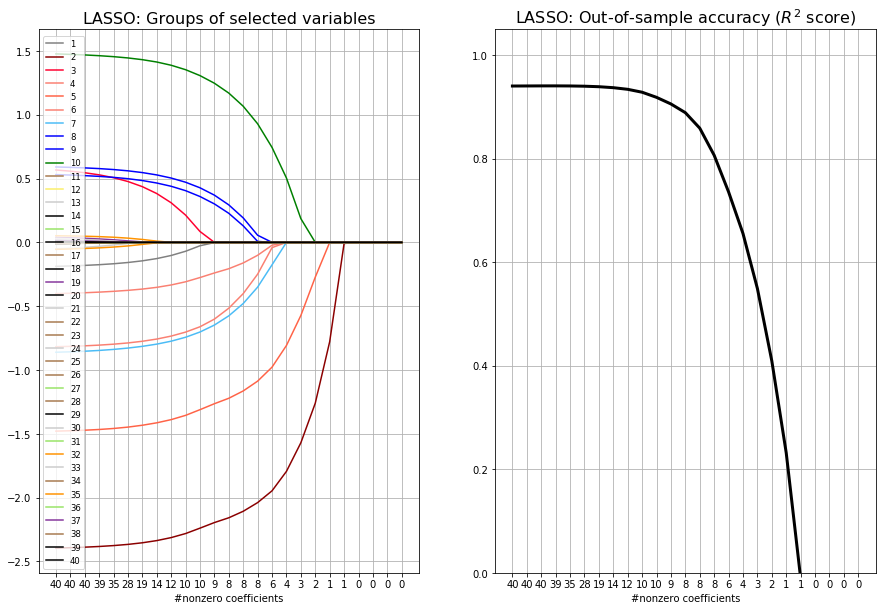

In [200]:
# 5 correlated vars at ~50% / dataset: 10/40 relevant variables, linear ground truth, some noise
rs = np.random.RandomState(1)
n_samples = 1000
n_feat = 40
n_feat_relevant = 10
epsilon = rs.randn(n_samples)
true_coefs = rs.randn(n_feat)
true_coefs[n_feat_relevant:] = 0
X = rs.randn(n_samples, n_feat)

n_corr_feat = 5
cov = np.ones((n_corr_feat, n_corr_feat)) * .5
cov[np.diag_indices(n_corr_feat)] = 1

X_corr = rs.multivariate_normal(mean=np.zeros((n_corr_feat)), cov=cov, size=n_samples)
X[:, 0:n_corr_feat] = X_corr
y = (true_coefs * X).sum(axis=1) + epsilon

# ordinary least squares
model = OLS(y, X)
res = model.fit()
lr_coefs = res.params
lr_pvalues = res.pvalues

# compute Lasso regularization paths
C_grid = np.logspace(-2, 1, 25)
coef_list, acc_list, nonzero_list = compute_Lasso_regpath(X, y, C_grid)

plot_lr(true_coefs, lr_coefs, lr_pvalues)
plot_regr_paths(coef_list, acc_list, nonzero_list, C_grid)

In [ ]:
### observation: 10/10 variables are significant, the 5/5 (?) corr. variables are selected as predictive

alpha: 0.0100 acc: 0.91 active_coefs: 40
alpha: 0.0133 acc: 0.91 active_coefs: 40
alpha: 0.0178 acc: 0.91 active_coefs: 40
alpha: 0.0237 acc: 0.91 active_coefs: 39
alpha: 0.0316 acc: 0.91 active_coefs: 33
alpha: 0.0422 acc: 0.91 active_coefs: 30
alpha: 0.0562 acc: 0.91 active_coefs: 22
alpha: 0.0750 acc: 0.90 active_coefs: 14
alpha: 0.1000 acc: 0.89 active_coefs: 11
alpha: 0.1334 acc: 0.88 active_coefs: 10
alpha: 0.1778 acc: 0.85 active_coefs: 9
alpha: 0.2371 acc: 0.82 active_coefs: 9
alpha: 0.3162 acc: 0.78 active_coefs: 5
alpha: 0.4217 acc: 0.74 active_coefs: 5
alpha: 0.5623 acc: 0.66 active_coefs: 5
alpha: 0.7499 acc: 0.61 active_coefs: 4
alpha: 1.0000 acc: 0.57 active_coefs: 3
alpha: 1.3335 acc: 0.50 active_coefs: 2
alpha: 1.7783 acc: 0.38 active_coefs: 2
alpha: 2.3714 acc: 0.18 active_coefs: 1
alpha: 3.1623 acc: -0.01 active_coefs: 0
alpha: 4.2170 acc: -0.01 active_coefs: 0
alpha: 5.6234 acc: -0.01 active_coefs: 0
alpha: 7.4989 acc: -0.01 active_coefs: 0
alpha: 10.0000 acc: -0.01 

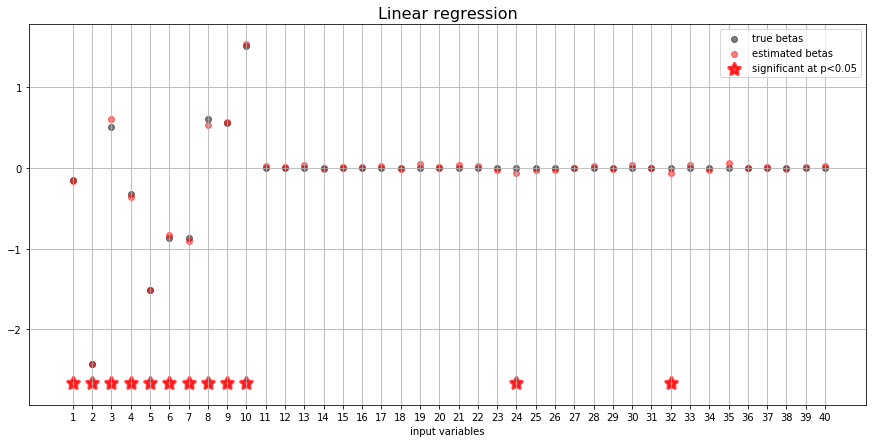

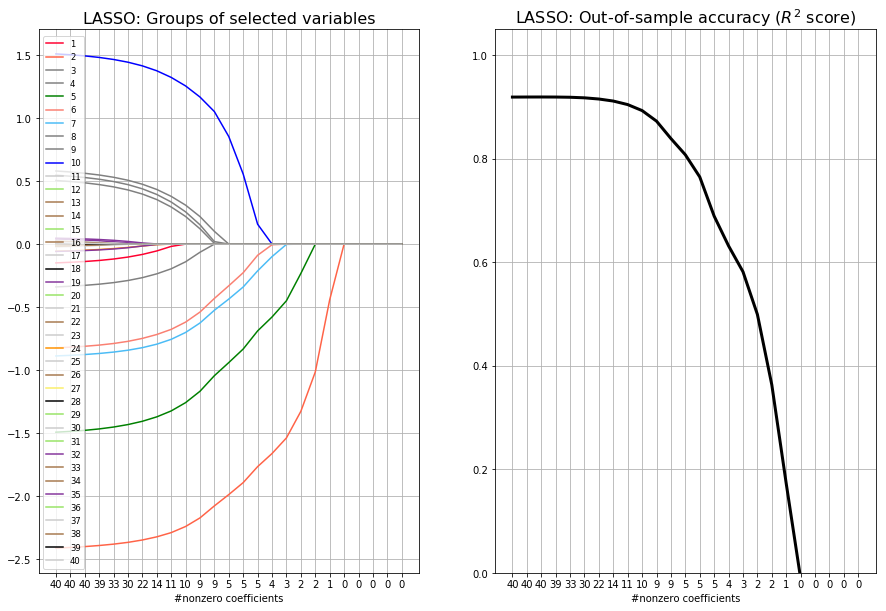

In [201]:
# 10 correlated vars at ~50% / dataset: 10/40 relevant variables, linear ground truth, some noise
rs = np.random.RandomState(1)
n_samples = 1000
n_feat = 40
n_feat_relevant = 10
epsilon = rs.randn(n_samples)
true_coefs = rs.randn(n_feat)
true_coefs[n_feat_relevant:] = 0
X = rs.randn(n_samples, n_feat)

n_corr_feat = 10
cov = np.ones((n_corr_feat, n_corr_feat)) * .5
cov[np.diag_indices(n_corr_feat)] = 1

X_corr = rs.multivariate_normal(mean=np.zeros((n_corr_feat)), cov=cov, size=n_samples)
X[:, 0:n_corr_feat] = X_corr
y = (true_coefs * X).sum(axis=1) + epsilon

# ordinary least squares
model = OLS(y, X)
res = model.fit()
lr_coefs = res.params
lr_pvalues = res.pvalues

# compute Lasso regularization paths
C_grid = np.logspace(-2, 1, 25)
coef_list, acc_list, nonzero_list = compute_Lasso_regpath(X, y, C_grid)

plot_lr(true_coefs, lr_coefs, lr_pvalues)
plot_regr_paths(coef_list, acc_list, nonzero_list, C_grid)

In [ ]:
### observation: 10/10 variables are significant, the 9/10 (?) corr. variables are selected as predictive

alpha: 0.0100 acc: 0.92 active_coefs: 40
alpha: 0.0133 acc: 0.92 active_coefs: 40
alpha: 0.0178 acc: 0.92 active_coefs: 39
alpha: 0.0237 acc: 0.92 active_coefs: 39
alpha: 0.0316 acc: 0.93 active_coefs: 36
alpha: 0.0422 acc: 0.93 active_coefs: 28
alpha: 0.0562 acc: 0.92 active_coefs: 20
alpha: 0.0750 acc: 0.92 active_coefs: 14
alpha: 0.1000 acc: 0.92 active_coefs: 11
alpha: 0.1334 acc: 0.92 active_coefs: 9
alpha: 0.1778 acc: 0.91 active_coefs: 9
alpha: 0.2371 acc: 0.89 active_coefs: 9
alpha: 0.3162 acc: 0.87 active_coefs: 8
alpha: 0.4217 acc: 0.82 active_coefs: 8
alpha: 0.5623 acc: 0.75 active_coefs: 8
alpha: 0.7499 acc: 0.65 active_coefs: 6
alpha: 1.0000 acc: 0.52 active_coefs: 4
alpha: 1.3335 acc: 0.31 active_coefs: 3
alpha: 1.7783 acc: 0.09 active_coefs: 2
alpha: 2.3714 acc: -0.01 active_coefs: 0
alpha: 3.1623 acc: -0.01 active_coefs: 0
alpha: 4.2170 acc: -0.01 active_coefs: 0
alpha: 5.6234 acc: -0.01 active_coefs: 0
alpha: 7.4989 acc: -0.01 active_coefs: 0
alpha: 10.0000 acc: -0.01 

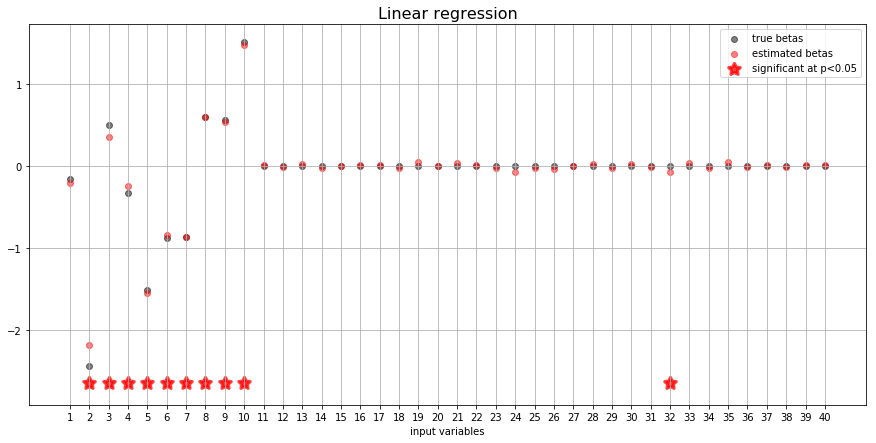

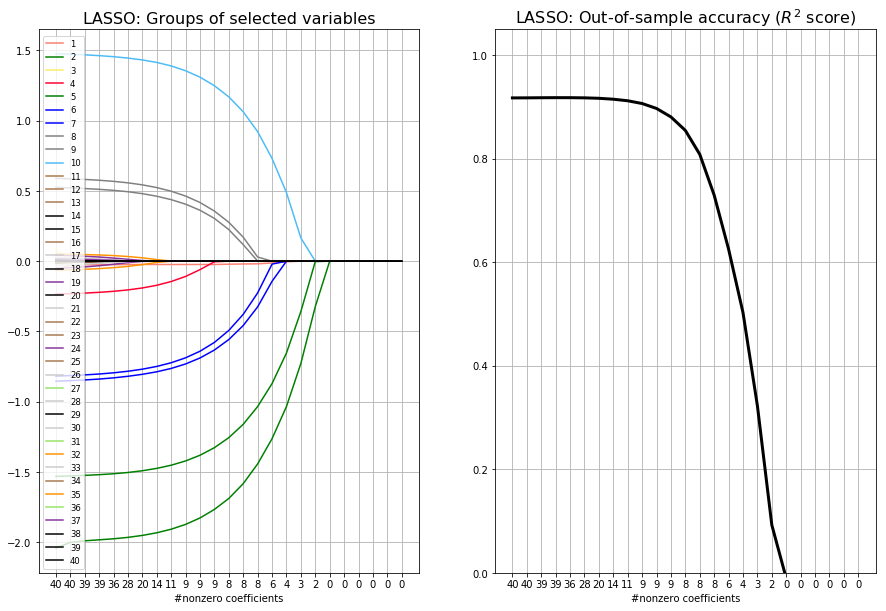

In [202]:
# 3 correlated vars at ~95% / dataset: 10/40 relevant variables, linear ground truth, some noise
rs = np.random.RandomState(1)
n_samples = 1000
n_feat = 40
n_feat_relevant = 10
epsilon = rs.randn(n_samples)
true_coefs = rs.randn(n_feat)
true_coefs[n_feat_relevant:] = 0
X = rs.randn(n_samples, n_feat)

n_corr_feat = 3
cov = np.ones((n_corr_feat, n_corr_feat)) * .95
cov[np.diag_indices(n_corr_feat)] = 1

X_corr = rs.multivariate_normal(mean=np.zeros((n_corr_feat)), cov=cov, size=n_samples)
X[:, 0:n_corr_feat] = X_corr
y = (true_coefs * X).sum(axis=1) + epsilon

# ordinary least squares
model = OLS(y, X)
res = model.fit()
lr_coefs = res.params
lr_pvalues = res.pvalues

# compute Lasso regularization paths
C_grid = np.logspace(-2, 1, 25)
coef_list, acc_list, nonzero_list = compute_Lasso_regpath(X, y, C_grid)

plot_lr(true_coefs, lr_coefs, lr_pvalues)
plot_regr_paths(coef_list, acc_list, nonzero_list, C_grid)

### observation: 2/3 corr. variables are significant, different (!) 2/3 highly corr. variables are selected as predictive

alpha: 0.0100 acc: 0.94 active_coefs: 40
alpha: 0.0133 acc: 0.94 active_coefs: 40
alpha: 0.0178 acc: 0.94 active_coefs: 39
alpha: 0.0237 acc: 0.95 active_coefs: 39
alpha: 0.0316 acc: 0.95 active_coefs: 35
alpha: 0.0422 acc: 0.95 active_coefs: 25
alpha: 0.0562 acc: 0.95 active_coefs: 19
alpha: 0.0750 acc: 0.95 active_coefs: 12
alpha: 0.1000 acc: 0.94 active_coefs: 10
alpha: 0.1334 acc: 0.94 active_coefs: 8
alpha: 0.1778 acc: 0.94 active_coefs: 8
alpha: 0.2371 acc: 0.93 active_coefs: 8
alpha: 0.3162 acc: 0.92 active_coefs: 8
alpha: 0.4217 acc: 0.89 active_coefs: 8
alpha: 0.5623 acc: 0.84 active_coefs: 8
alpha: 0.7499 acc: 0.78 active_coefs: 6
alpha: 1.0000 acc: 0.71 active_coefs: 3
alpha: 1.3335 acc: 0.61 active_coefs: 3
alpha: 1.7783 acc: 0.51 active_coefs: 2
alpha: 2.3714 acc: 0.40 active_coefs: 2
alpha: 3.1623 acc: 0.21 active_coefs: 2
alpha: 4.2170 acc: -0.01 active_coefs: 0
alpha: 5.6234 acc: -0.01 active_coefs: 0
alpha: 7.4989 acc: -0.01 active_coefs: 0
alpha: 10.0000 acc: -0.01 ac

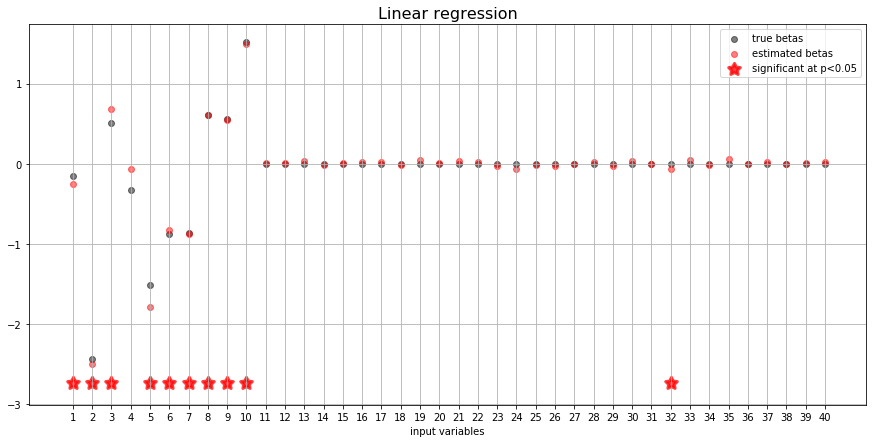

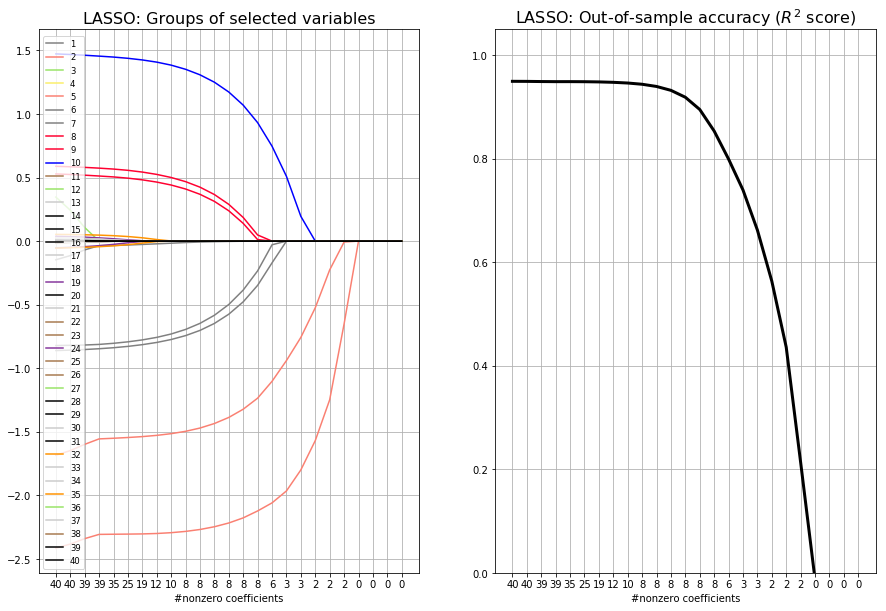

In [203]:
# 5 correlated vars at ~95% / dataset: 10/40 relevant variables, linear ground truth, some noise
rs = np.random.RandomState(1)
n_samples = 1000
n_feat = 40
n_feat_relevant = 10
epsilon = rs.randn(n_samples)
true_coefs = rs.randn(n_feat)
true_coefs[n_feat_relevant:] = 0
X = rs.randn(n_samples, n_feat)

n_corr_feat = 5
cov = np.ones((n_corr_feat, n_corr_feat)) * .95
cov[np.diag_indices(n_corr_feat)] = 1

X_corr = rs.multivariate_normal(mean=np.zeros((n_corr_feat)), cov=cov, size=n_samples)
X[:, 0:n_corr_feat] = X_corr
y = (true_coefs * X).sum(axis=1) + epsilon

# ordinary least squares
model = OLS(y, X)
res = model.fit()
lr_coefs = res.params
lr_pvalues = res.pvalues

# compute Lasso regularization paths
C_grid = np.logspace(-2, 1, 25)
coef_list, acc_list, nonzero_list = compute_Lasso_regpath(X, y, C_grid)

plot_lr(true_coefs, lr_coefs, lr_pvalues)
plot_regr_paths(coef_list, acc_list, nonzero_list, C_grid)

### observation: 4/5 highly corr. variables are significant, different (!) 3/5 highly corr. variables are selected as predictive

alpha: 0.0100 acc: 0.90 active_coefs: 40
alpha: 0.0133 acc: 0.90 active_coefs: 40
alpha: 0.0178 acc: 0.90 active_coefs: 40
alpha: 0.0237 acc: 0.90 active_coefs: 40
alpha: 0.0316 acc: 0.90 active_coefs: 31
alpha: 0.0422 acc: 0.90 active_coefs: 26
alpha: 0.0562 acc: 0.90 active_coefs: 16
alpha: 0.0750 acc: 0.90 active_coefs: 11
alpha: 0.1000 acc: 0.90 active_coefs: 7
alpha: 0.1334 acc: 0.90 active_coefs: 5
alpha: 0.1778 acc: 0.90 active_coefs: 5
alpha: 0.2371 acc: 0.90 active_coefs: 5
alpha: 0.3162 acc: 0.90 active_coefs: 5
alpha: 0.4217 acc: 0.89 active_coefs: 5
alpha: 0.5623 acc: 0.88 active_coefs: 5
alpha: 0.7499 acc: 0.87 active_coefs: 4
alpha: 1.0000 acc: 0.83 active_coefs: 4
alpha: 1.3335 acc: 0.76 active_coefs: 3
alpha: 1.7783 acc: 0.63 active_coefs: 2
alpha: 2.3714 acc: 0.39 active_coefs: 2
alpha: 3.1623 acc: -0.00 active_coefs: 1
alpha: 4.2170 acc: -0.00 active_coefs: 0
alpha: 5.6234 acc: -0.00 active_coefs: 0
alpha: 7.4989 acc: -0.00 active_coefs: 0
alpha: 10.0000 acc: -0.00 ac

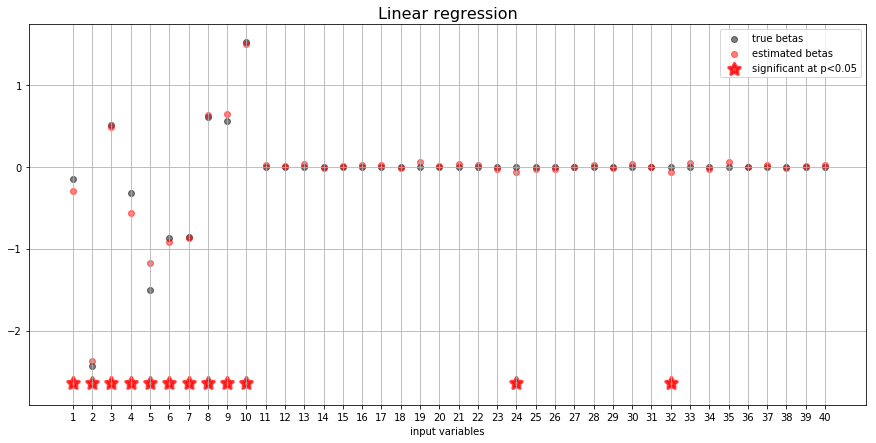

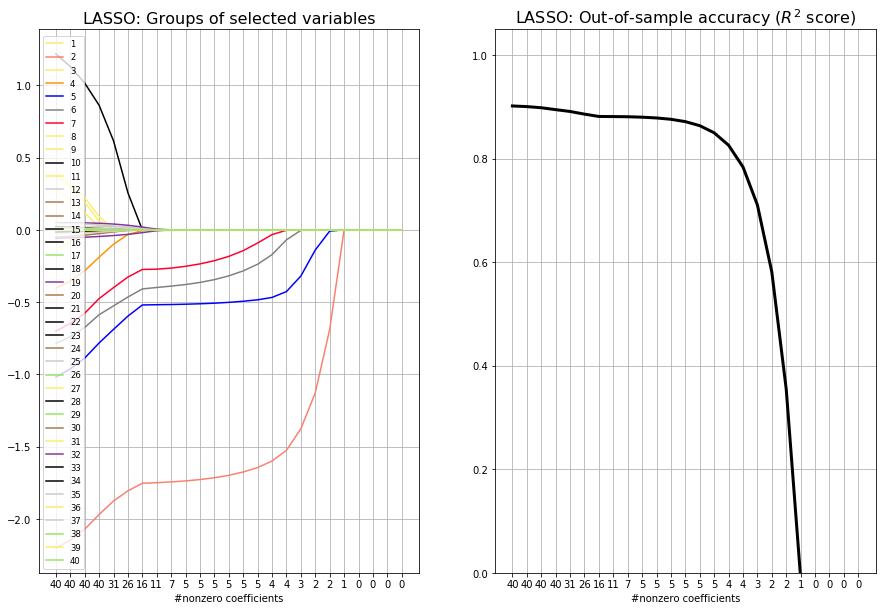

In [204]:
# 10 correlated vars at ~95% / dataset: 10/40 relevant variables, linear ground truth, some noise
rs = np.random.RandomState(1)
n_samples = 1000
n_feat = 40
n_feat_relevant = 10
epsilon = rs.randn(n_samples)
true_coefs = rs.randn(n_feat)
true_coefs[n_feat_relevant:] = 0
X = rs.randn(n_samples, n_feat)

n_corr_feat = 10
cov = np.ones((n_corr_feat, n_corr_feat)) * .95
cov[np.diag_indices(n_corr_feat)] = 1

X_corr = rs.multivariate_normal(mean=np.zeros((n_corr_feat)), cov=cov, size=n_samples)
X[:, 0:n_corr_feat] = X_corr
y = (true_coefs * X).sum(axis=1) + epsilon

# ordinary least squares
model = OLS(y, X)
res = model.fit()
lr_coefs = res.params
lr_pvalues = res.pvalues

# compute Lasso regularization paths
C_grid = np.logspace(-2, 1, 25)
coef_list, acc_list, nonzero_list = compute_Lasso_regpath(X, y, C_grid)

plot_lr(true_coefs, lr_coefs, lr_pvalues)
plot_regr_paths(coef_list, acc_list, nonzero_list, C_grid)

### observation: 10/10 highly corr. variables are significant, different (!) 4/10 highly corr. variables are selected as predictive with reasonable accuracy around R2=0.9 -> a few representative variables are easily found by Lasso without false positive while sign. testing yields 2 false positives -> corelation among variables appears to inflate Type-1 error

alpha: 0.0100 acc: 0.97 active_coefs: 39
alpha: 0.0133 acc: 0.97 active_coefs: 39
alpha: 0.0178 acc: 0.97 active_coefs: 38
alpha: 0.0237 acc: 0.97 active_coefs: 34
alpha: 0.0316 acc: 0.96 active_coefs: 30
alpha: 0.0422 acc: 0.96 active_coefs: 21
alpha: 0.0562 acc: 0.96 active_coefs: 18
alpha: 0.0750 acc: 0.96 active_coefs: 16
alpha: 0.1000 acc: 0.96 active_coefs: 16
alpha: 0.1334 acc: 0.96 active_coefs: 16
alpha: 0.1778 acc: 0.95 active_coefs: 15
alpha: 0.2371 acc: 0.95 active_coefs: 15
alpha: 0.3162 acc: 0.94 active_coefs: 15
alpha: 0.4217 acc: 0.94 active_coefs: 15
alpha: 0.5623 acc: 0.92 active_coefs: 15
alpha: 0.7499 acc: 0.90 active_coefs: 14
alpha: 1.0000 acc: 0.86 active_coefs: 13
alpha: 1.3335 acc: 0.79 active_coefs: 12
alpha: 1.7783 acc: 0.69 active_coefs: 11
alpha: 2.3714 acc: 0.54 active_coefs: 9
alpha: 3.1623 acc: 0.29 active_coefs: 7
alpha: 4.2170 acc: -0.00 active_coefs: 1
alpha: 5.6234 acc: -0.00 active_coefs: 0
alpha: 7.4989 acc: -0.00 active_coefs: 0
alpha: 10.0000 acc

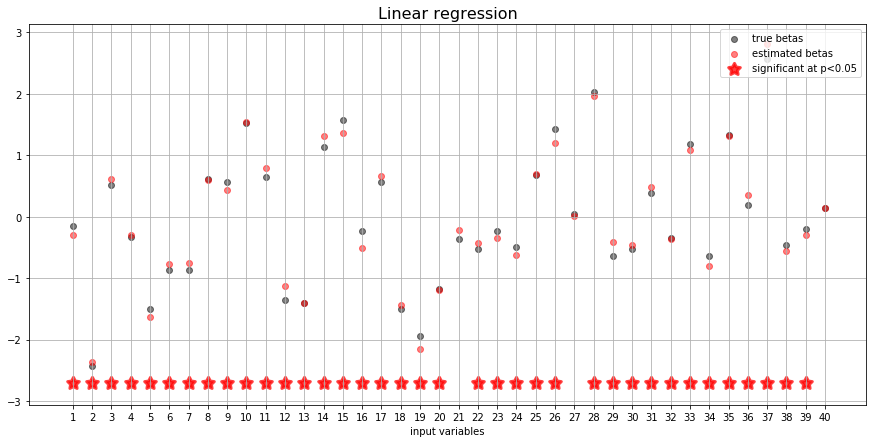

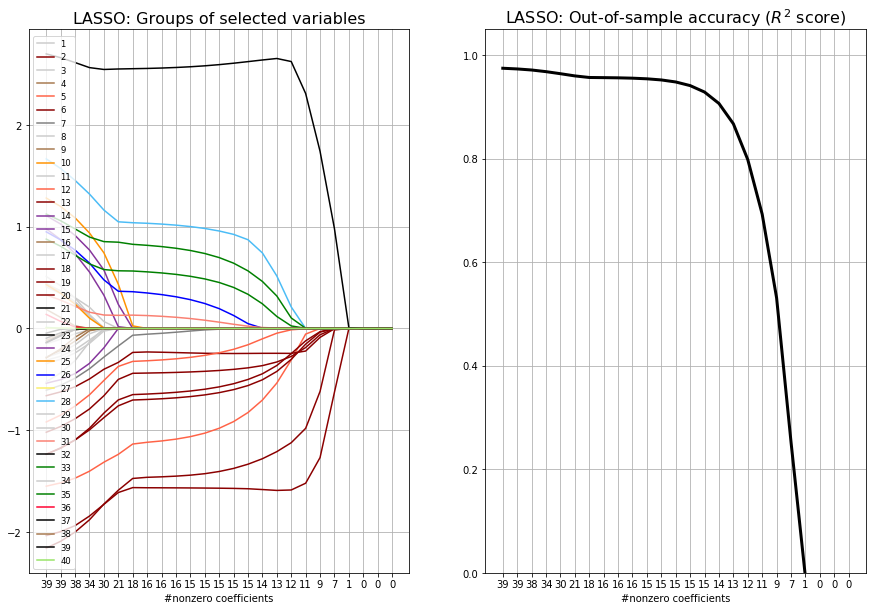

In [205]:
# 4 groups of 10 correlated vars at ~95% / dataset: 40/40 relevant variables, linear ground truth, some noise
rs = np.random.RandomState(1)
n_samples = 1000
n_feat = 40
n_feat_relevant = 40
epsilon = rs.randn(n_samples)
true_coefs = rs.randn(n_feat)
true_coefs[n_feat_relevant:] = 0
#X = rs.randn(n_samples, n_feat)

n_corr_feat = 10
cov = np.ones((n_corr_feat, n_corr_feat)) * .95
cov[np.diag_indices(n_corr_feat)] = 1
X_corr = rs.multivariate_normal(mean=np.zeros((n_corr_feat)), cov=cov, size=n_samples)
X[:, 0:10] = X_corr

n_corr_feat = 10
cov = np.ones((n_corr_feat, n_corr_feat)) * .95
cov[np.diag_indices(n_corr_feat)] = 1
X_corr = rs.multivariate_normal(mean=np.zeros((n_corr_feat)), cov=cov, size=n_samples)
X[:, 10:20] = X_corr

n_corr_feat = 10
cov = np.ones((n_corr_feat, n_corr_feat)) * .95
cov[np.diag_indices(n_corr_feat)] = 1
X_corr = rs.multivariate_normal(mean=np.zeros((n_corr_feat)), cov=cov, size=n_samples)
X[:, 20:30] = X_corr

n_corr_feat = 10
cov = np.ones((n_corr_feat, n_corr_feat)) * .95
cov[np.diag_indices(n_corr_feat)] = 1
X_corr = rs.multivariate_normal(mean=np.zeros((n_corr_feat)), cov=cov, size=n_samples)
X[:, 30:40] = X_corr

y = (true_coefs * X).sum(axis=1) + epsilon

# ordinary least squares
model = OLS(y, X)
res = model.fit()
lr_coefs = res.params
lr_pvalues = res.pvalues

# compute Lasso regularization paths
C_grid = np.logspace(-2, 1, 25)
coef_list, acc_list, nonzero_list = compute_Lasso_regpath(X, y, C_grid)

plot_lr(true_coefs, lr_coefs, lr_pvalues)
plot_regr_paths(coef_list, acc_list, nonzero_list, C_grid)

### observation: significance yields 3 false negatives; Lasso yields stable R2>0.9 with roughly 16/40 active variables capturing 4 real sources of variation

alpha: 0.0100 acc: 0.99 active_coefs: 36
alpha: 0.0133 acc: 0.99 active_coefs: 35
alpha: 0.0178 acc: 0.98 active_coefs: 33
alpha: 0.0237 acc: 0.96 active_coefs: 32
alpha: 0.0316 acc: 0.94 active_coefs: 28
alpha: 0.0422 acc: 0.90 active_coefs: 25
alpha: 0.0562 acc: 0.86 active_coefs: 21
alpha: 0.0750 acc: 0.85 active_coefs: 15
alpha: 0.1000 acc: 0.84 active_coefs: 14
alpha: 0.1334 acc: 0.84 active_coefs: 14
alpha: 0.1778 acc: 0.83 active_coefs: 13
alpha: 0.2371 acc: 0.82 active_coefs: 13
alpha: 0.3162 acc: 0.80 active_coefs: 12
alpha: 0.4217 acc: 0.77 active_coefs: 12
alpha: 0.5623 acc: 0.71 active_coefs: 13
alpha: 0.7499 acc: 0.60 active_coefs: 12
alpha: 1.0000 acc: 0.43 active_coefs: 12
alpha: 1.3335 acc: 0.26 active_coefs: 8
alpha: 1.7783 acc: 0.02 active_coefs: 5
alpha: 2.3714 acc: -0.05 active_coefs: 0
alpha: 3.1623 acc: -0.05 active_coefs: 0
alpha: 4.2170 acc: -0.05 active_coefs: 0
alpha: 5.6234 acc: -0.05 active_coefs: 0
alpha: 7.4989 acc: -0.05 active_coefs: 0
alpha: 10.0000 acc

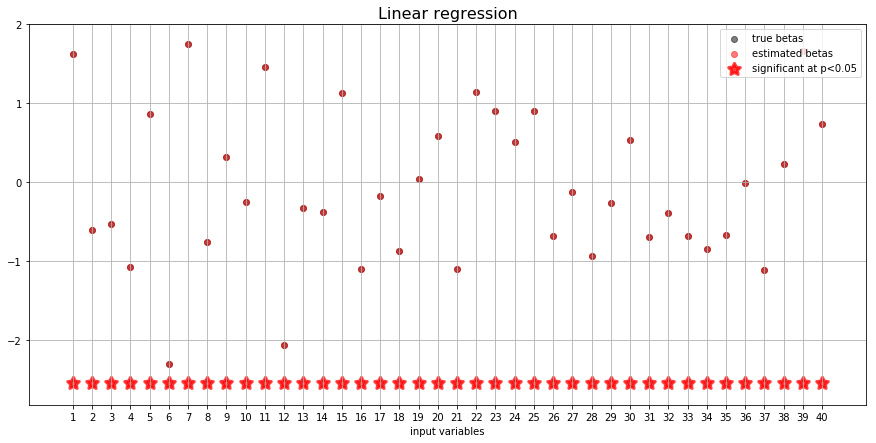

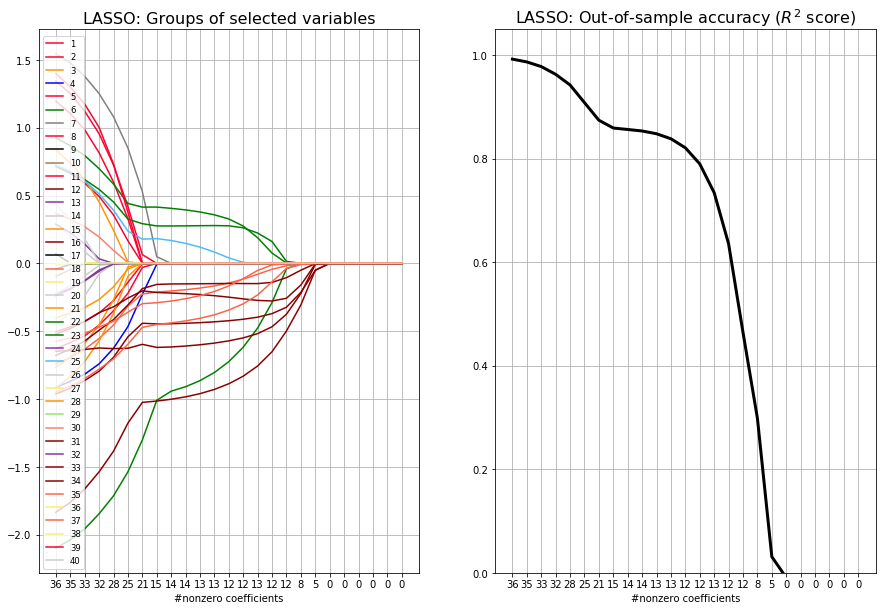

In [207]:
# 4 groups of 10 correlated vars at ~95% / dataset: 40/40 relevant variables, linear ground truth, NO noise
rs = np.random.RandomState(1)
n_samples = 1000
n_feat = 40
n_feat_relevant = 40
#epsilon = rs.randn(n_samples)
true_coefs = rs.randn(n_feat)
true_coefs[n_feat_relevant:] = 0
X = rs.randn(n_samples, n_feat)

n_corr_feat = 10
cov = np.ones((n_corr_feat, n_corr_feat)) * .95
cov[np.diag_indices(n_corr_feat)] = 1
X_corr = rs.multivariate_normal(mean=np.zeros((n_corr_feat)), cov=cov, size=n_samples)
X[:, 0:10] = X_corr

n_corr_feat = 10
cov = np.ones((n_corr_feat, n_corr_feat)) * .95
cov[np.diag_indices(n_corr_feat)] = 1
X_corr = rs.multivariate_normal(mean=np.zeros((n_corr_feat)), cov=cov, size=n_samples)
X[:, 10:20] = X_corr

n_corr_feat = 10
cov = np.ones((n_corr_feat, n_corr_feat)) * .95
cov[np.diag_indices(n_corr_feat)] = 1
X_corr = rs.multivariate_normal(mean=np.zeros((n_corr_feat)), cov=cov, size=n_samples)
X[:, 20:30] = X_corr

n_corr_feat = 10
cov = np.ones((n_corr_feat, n_corr_feat)) * .95
cov[np.diag_indices(n_corr_feat)] = 1
X_corr = rs.multivariate_normal(mean=np.zeros((n_corr_feat)), cov=cov, size=n_samples)
X[:, 30:40] = X_corr

#y = (true_coefs * X).sum(axis=1) + epsilon
y = (true_coefs * X).sum(axis=1)

# ordinary least squares
model = OLS(y, X)
res = model.fit()
lr_coefs = res.params
lr_pvalues = res.pvalues

# compute Lasso regularization paths
C_grid = np.logspace(-2, 1, 25)
coef_list, acc_list, nonzero_list = compute_Lasso_regpath(X, y, C_grid)

plot_lr(true_coefs, lr_coefs, lr_pvalues)
plot_regr_paths(coef_list, acc_list, nonzero_list, C_grid)

### observation: significance yields NO false negatives anymore, Lasso has roughly stable prediction around R2=0.9 with 12-14 variables but cannot reduce further

alpha: 0.0100 acc: 0.99 active_coefs: 36
alpha: 0.0133 acc: 0.99 active_coefs: 35
alpha: 0.0178 acc: 0.98 active_coefs: 32
alpha: 0.0237 acc: 0.96 active_coefs: 30
alpha: 0.0316 acc: 0.94 active_coefs: 26
alpha: 0.0422 acc: 0.91 active_coefs: 21
alpha: 0.0562 acc: 0.88 active_coefs: 16
alpha: 0.0750 acc: 0.86 active_coefs: 13
alpha: 0.1000 acc: 0.86 active_coefs: 12
alpha: 0.1334 acc: 0.85 active_coefs: 12
alpha: 0.1778 acc: 0.85 active_coefs: 12
alpha: 0.2371 acc: 0.83 active_coefs: 12
alpha: 0.3162 acc: 0.82 active_coefs: 12
alpha: 0.4217 acc: 0.78 active_coefs: 11
alpha: 0.5623 acc: 0.72 active_coefs: 11
alpha: 0.7499 acc: 0.61 active_coefs: 9
alpha: 1.0000 acc: 0.44 active_coefs: 7
alpha: 1.3335 acc: 0.26 active_coefs: 6
alpha: 1.7783 acc: -0.00 active_coefs: 0
alpha: 2.3714 acc: -0.00 active_coefs: 0
alpha: 3.1623 acc: -0.00 active_coefs: 0
alpha: 4.2170 acc: -0.00 active_coefs: 0
alpha: 5.6234 acc: -0.00 active_coefs: 0
alpha: 7.4989 acc: -0.00 active_coefs: 0
alpha: 10.0000 acc:

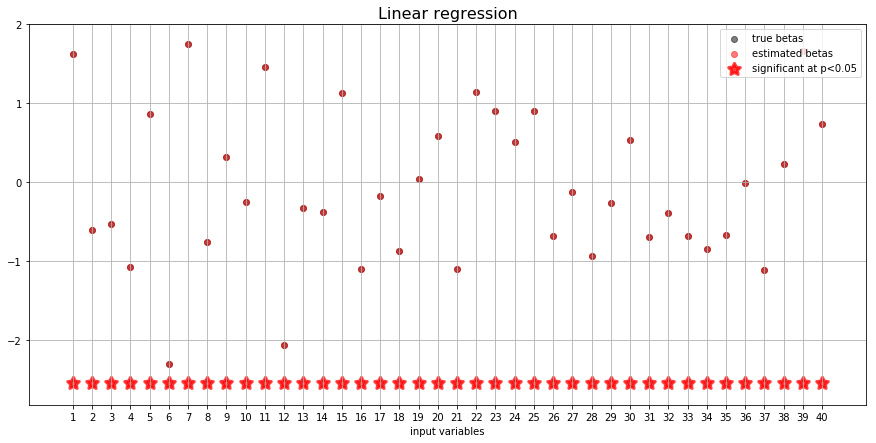

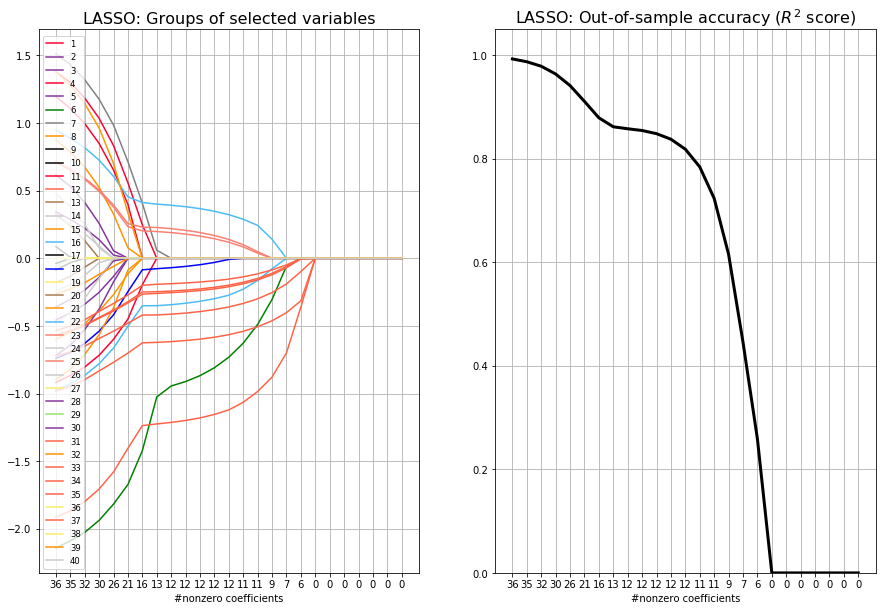

In [214]:
# 4 groups of 10 correlated vars at ~95% / dataset: 40/40 relevant variables, linear ground truth / NO noise
# 50,000 samples
rs = np.random.RandomState(1)
n_samples = 50000
n_feat = 40
n_feat_relevant = 40
#epsilon = rs.randn(n_samples)
true_coefs = rs.randn(n_feat)
true_coefs[n_feat_relevant:] = 0
X = rs.randn(n_samples, n_feat)

n_corr_feat = 10
cov = np.ones((n_corr_feat, n_corr_feat)) * .95
cov[np.diag_indices(n_corr_feat)] = 1
X_corr = rs.multivariate_normal(mean=np.zeros((n_corr_feat)), cov=cov, size=n_samples)
X[:, 0:10] = X_corr

n_corr_feat = 10
cov = np.ones((n_corr_feat, n_corr_feat)) * .95
cov[np.diag_indices(n_corr_feat)] = 1
X_corr = rs.multivariate_normal(mean=np.zeros((n_corr_feat)), cov=cov, size=n_samples)
X[:, 10:20] = X_corr

n_corr_feat = 10
cov = np.ones((n_corr_feat, n_corr_feat)) * .95
cov[np.diag_indices(n_corr_feat)] = 1
X_corr = rs.multivariate_normal(mean=np.zeros((n_corr_feat)), cov=cov, size=n_samples)
X[:, 20:30] = X_corr

n_corr_feat = 10
cov = np.ones((n_corr_feat, n_corr_feat)) * .95
cov[np.diag_indices(n_corr_feat)] = 1
X_corr = rs.multivariate_normal(mean=np.zeros((n_corr_feat)), cov=cov, size=n_samples)
X[:, 30:40] = X_corr

#y = (true_coefs * X).sum(axis=1) + epsilon
y = (true_coefs * X).sum(axis=1)

# ordinary least squares
model = OLS(y, X)
res = model.fit()
lr_coefs = res.params
lr_pvalues = res.pvalues

# compute Lasso regularization paths
C_grid = np.logspace(-2, 1, 25)
coef_list, acc_list, nonzero_list = compute_Lasso_regpath(X, y, C_grid)

plot_lr(true_coefs, lr_coefs, lr_pvalues)
plot_regr_paths(coef_list, acc_list, nonzero_list, C_grid)

In [212]:
### Lasso performance plateau around 12 variables is not a matter of sample size

(5000, 40)